In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

import importlib

from skbio import TreeNode
from SimulationResult import SimulationResult
from scipy.spatial.distance import pdist, squareform

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


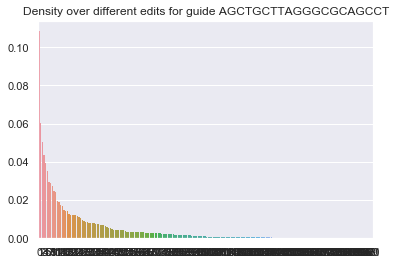

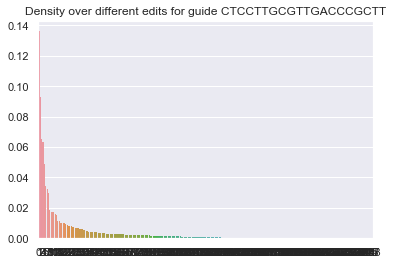

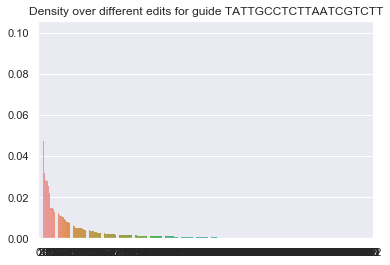

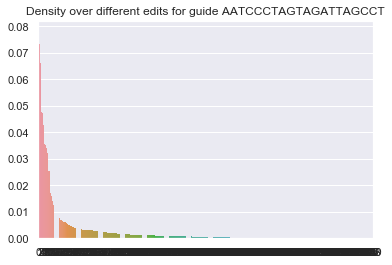

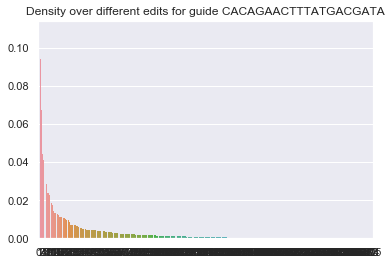

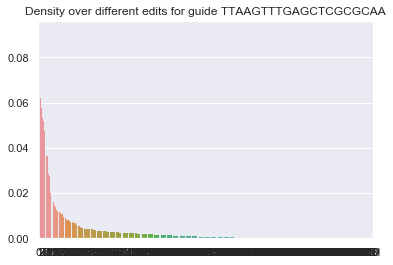

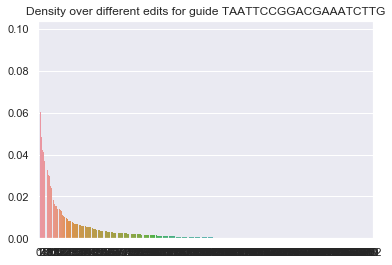

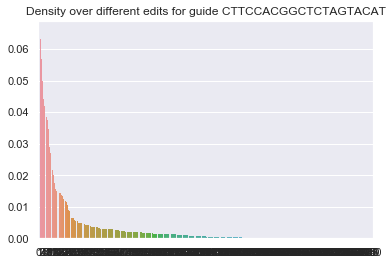

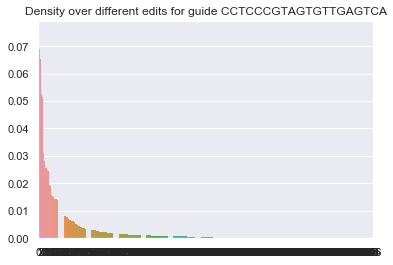

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        plt.figure()
        sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
        plt.title('Density over different edits for guide {0}'.format(guide))
        plt.show()
        plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]




In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""


Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


' \nQuestions\n1. tree or forest\n2. are the rates based on isolating a clone or from a forest\n3. yosef lab was a single tree?? no\n\ntry this instead: \nstart with many roots (a forest)\n\nreproduction rate varying / same ?vfr \n\n'

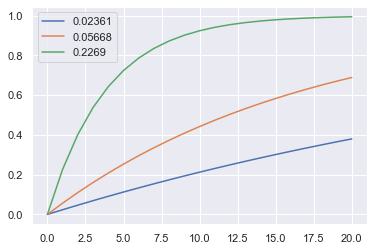

In [4]:
plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [5]:
import crispr_lib
importlib.reload(crispr_lib)
from crispr_lib import lineageSimulationFast


In [6]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 1000
num_arrays = 10

init_cell_list = [1, 10, 100]

debug = True 
compute_tree = False

if debug:
    lists_of_guides = [fast_guides]
    labels = ['fff']
    tree_depth = 15
    num_runs = 3
    n_subsample = 1000
    num_arrays = 10
    init_cell_list = [1, 10, 100]


Label: fff
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
[   17    39    61    76   102   140   196   232   243   380   383   400
   420   431   470   485   554   564   739   760   763   806   834   859
   871   919   963   981  1000  1034  1047  1089  1134  1166  1201  1228
  1235  1300  1363  1383  1417  1422  1426  1453  1471  1508  1524  1629
  1632  1652  1654  1673  1679  1681  1692  1758  1761  1765  1839  1842
  1848  1877  1906  1990  2010  2053  2179  2232  2237  2254  2263  2282
  2288  2301  2362  2406  2426  2442  2447  2487  2492  2496  2527  2550
  2571  2583  2638  2676  2682  2694  2714  2772  2794  2803  2851  2894
  2918  3055  3085  3096  3098  3132  3146  3322  3334  3384  3478  3516
  3578  3597  3645  3655  3671  3681  3710  3719  3737  3739  3750  3814


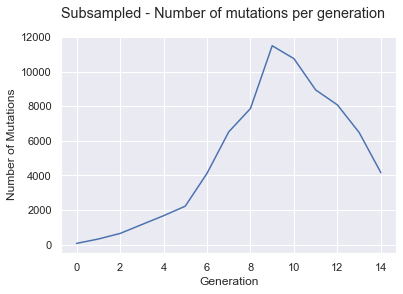

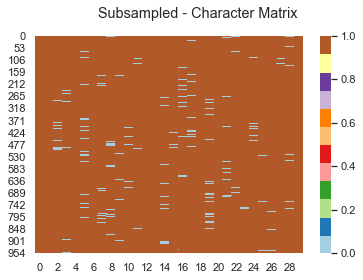

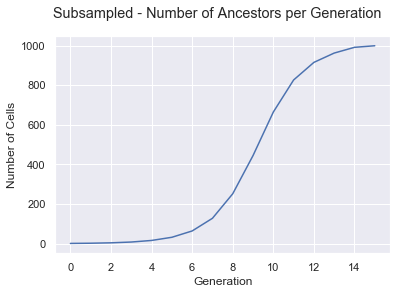

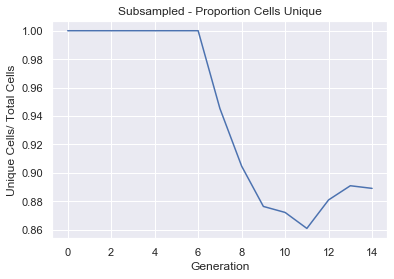

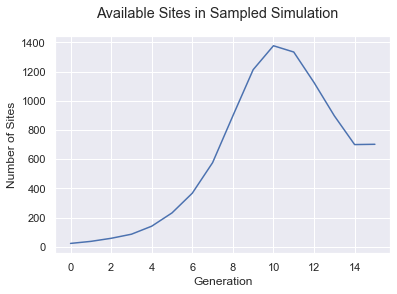

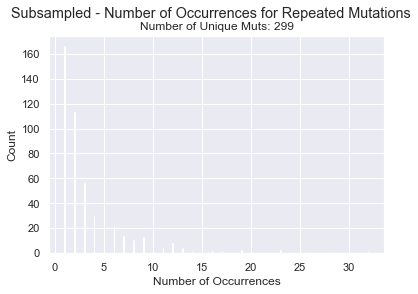

(1000, 30)
Time 1: 0.011811017990112305
Compute dictionary: 22.96676778793335
Conflict matrix is symmetric?  True
Total time: 22.9983811378479
Number of true recurrent muts:  496
Number of detected recurrent muts:  712
Number of true recurrent muts not detected: 7 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000]


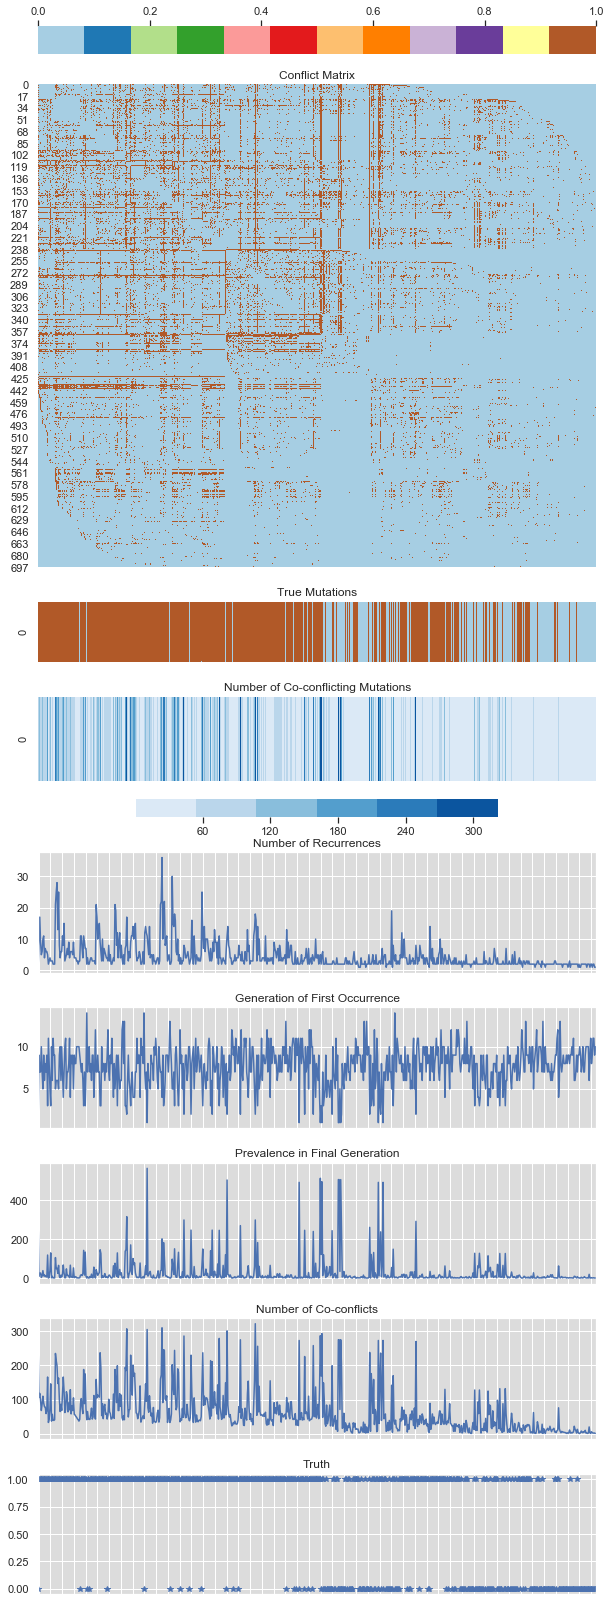

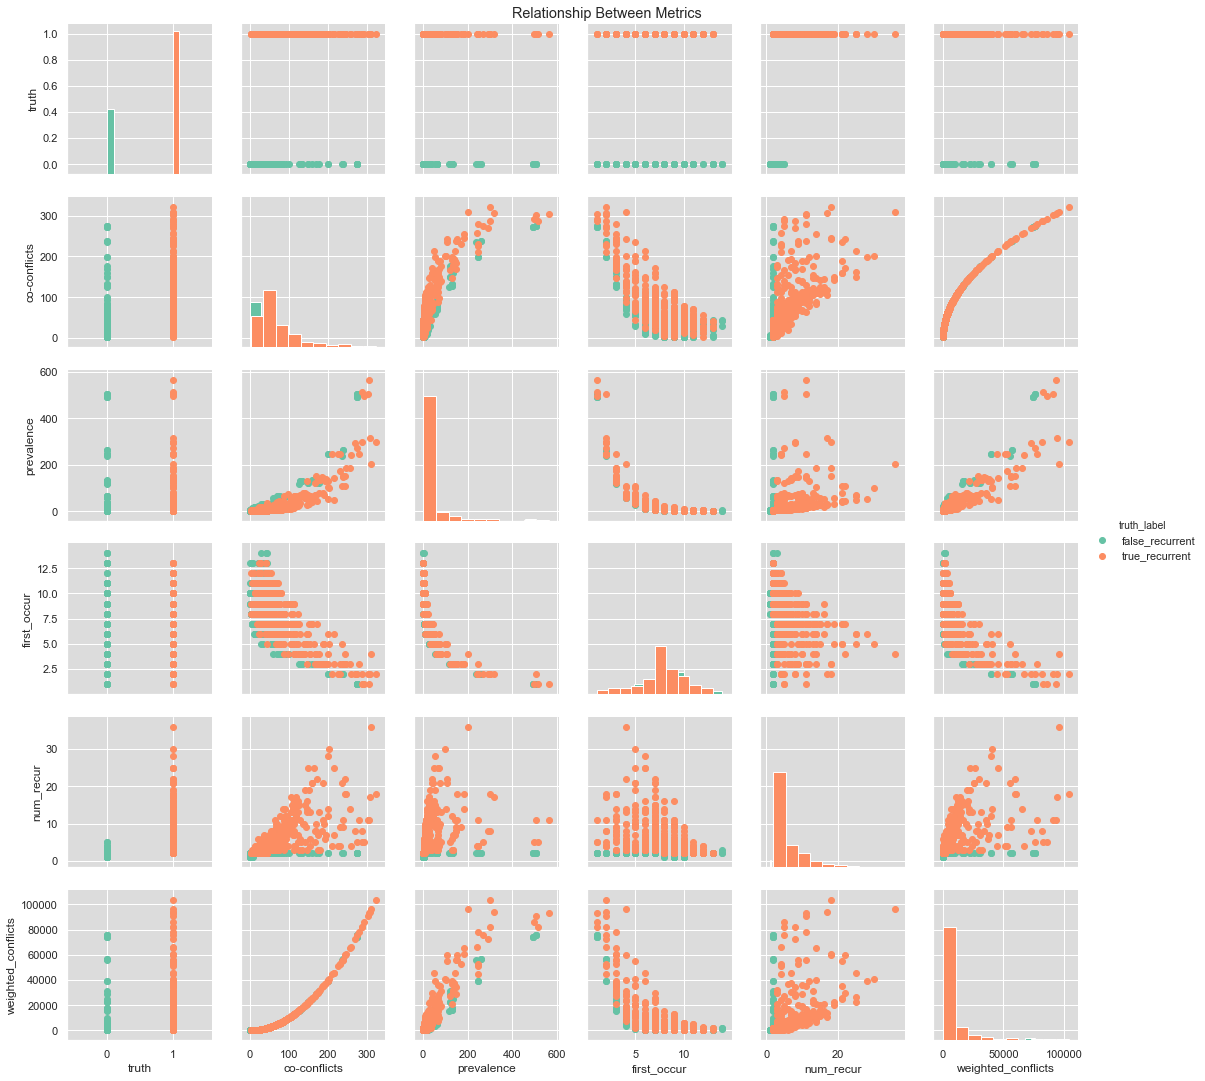

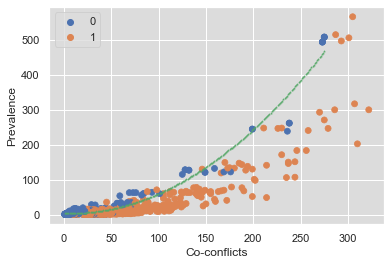

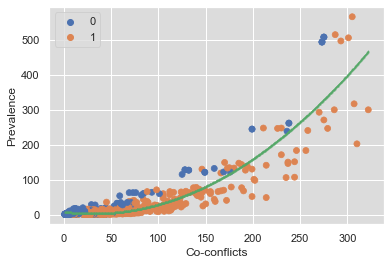

[   37    61    72   126   140   203   227   504   538   551   560   720
   800   806   824   825   829   863   870   877   880   881   883   887
   905   920   923   945   966   975  1113  1128  1210  1277  1339  1384
  1401  1420  1498  1526  1527  1535  1545  1569  1590  1610  1648  1664
  1704  1725  1835  1838  1840  1888  1916  2029  2035  2056  2073  2097
  2145  2186  2217  2245  2274  2277  2311  2336  2340  2375  2410  2421
  2456  2531  2620  2641  2663  2714  2728  2803  2822  2825  2826  2875
  2889  2945  2953  2972  3045  3071  3091  3110  3139  3252  3263  3335
  3336  3413  3418  3419  3431  3505  3529  3533  3551  3560  3591  3615
  3635  3659  3688  3726  3853  4025  4047  4094  4216  4318  4320  4338
  4359  4365  4375  4387  4393  4452  4491  4499  4516  4524  4562  4597
  4675  4694  4729  4730  4760  4782  4826  4830  4859  4929  4985  5016
  5020  5032  5045  5053  5065  5094  5103  5116  5135  5148  5181  5292
  5304  5326  5338  5346  5387  5416  5425  5428  5

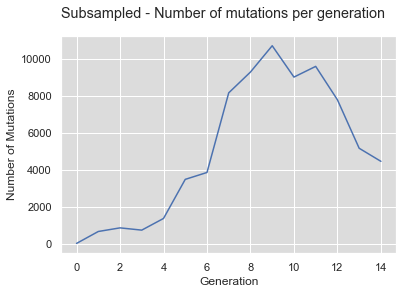

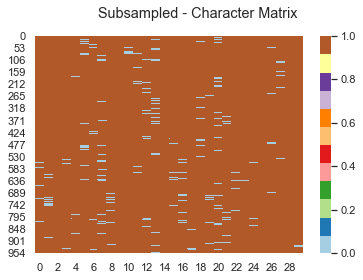

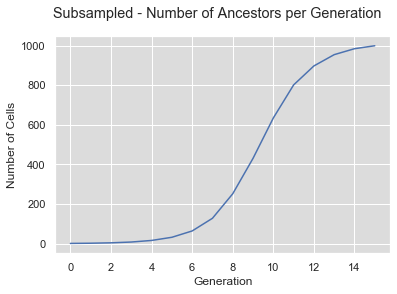

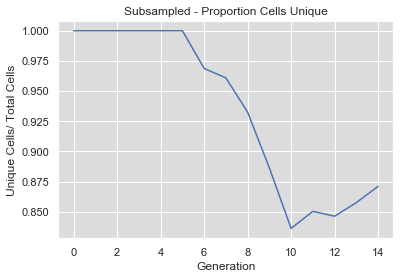

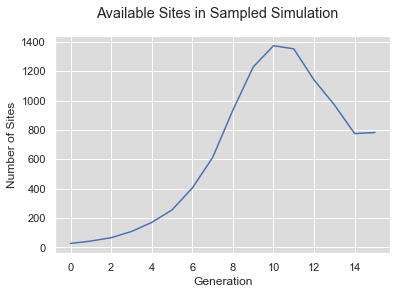

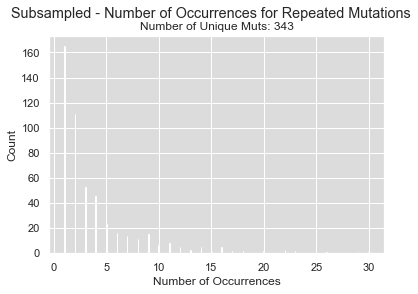

(1000, 30)
Time 1: 0.012890815734863281
Compute dictionary: 25.83246374130249
Conflict matrix is symmetric?  True
Total time: 25.85949683189392
Number of true recurrent muts:  502
Number of detected recurrent muts:  771
Number of true recurrent muts not detected: 3 with prevalence [1000, 1000, 1000]


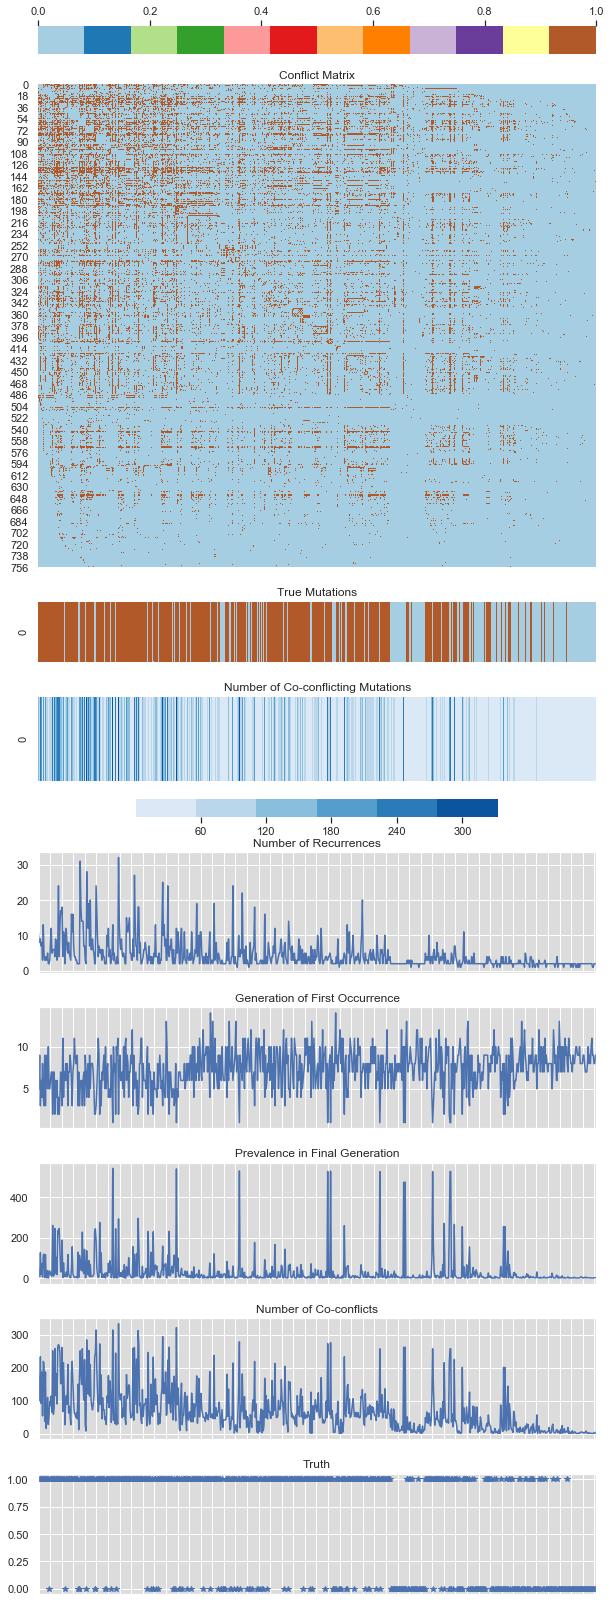

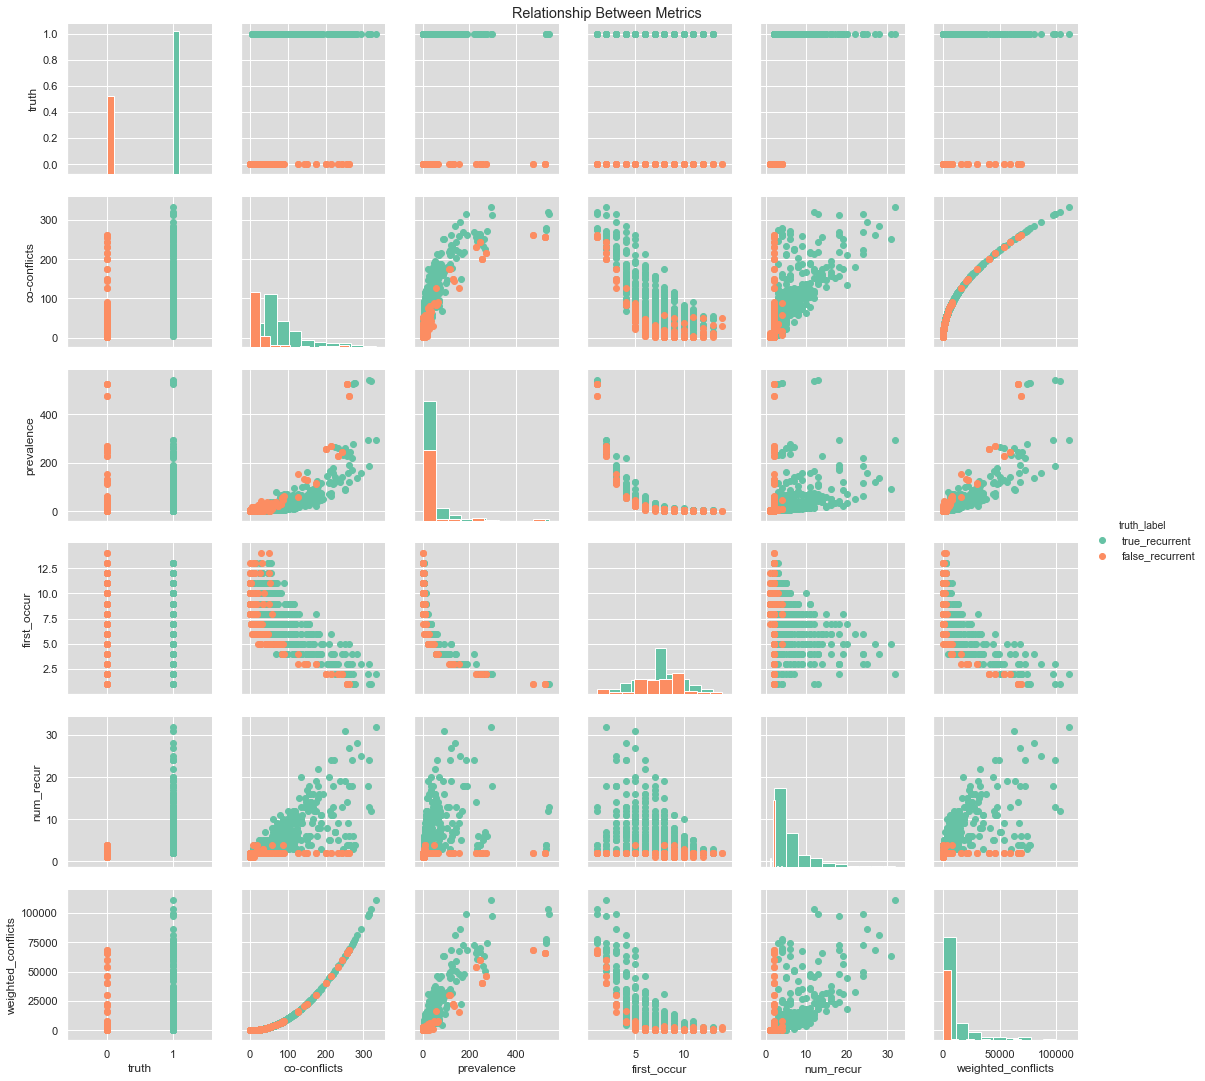

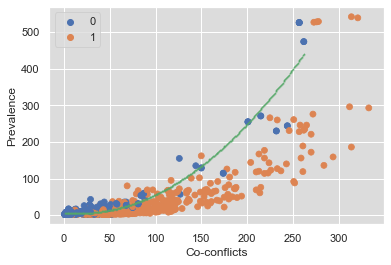

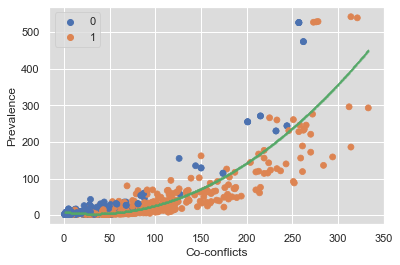

[   26    34    62    93   103   108   117   132   188   191   198   254
   263   279   331   347   524   558   726   734   816   819   983   995
  1075  1167  1236  1250  1262  1274  1396  1407  1477  1487  1563  1566
  1592  1593  1621  1644  1669  1718  1723  1734  1748  1778  1787  1790
  1817  1892  1955  1987  2000  2082  2144  2156  2188  2203  2251  2274
  2281  2285  2302  2334  2335  2357  2358  2364  2408  2423  2474  2509
  2521  2531  2628  2642  2683  2743  2785  2794  2810  2839  2881  2889
  2893  2967  2983  3016  3223  3269  3279  3360  3411  3422  3504  3507
  3548  3566  3574  3585  3621  3656  3679  3682  3714  3814  3850  3915
  3954  3982  4009  4024  4035  4047  4093  4101  4118  4148  4163  4223
  4306  4307  4370  4429  4532  4533  4566  4599  4612  4614  4650  4689
  4703  4754  4772  4871  4924  4963  4991  4993  5052  5056  5061  5078
  5086  5125  5230  5267  5269  5292  5364  5374  5386  5456  5507  5527
  5540  5560  5587  5592  5637  5689  5709  5732  5

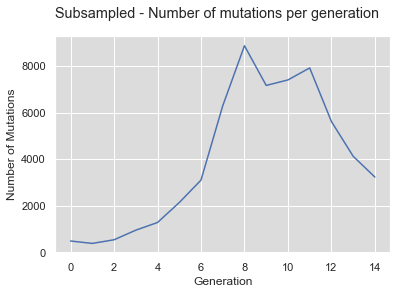

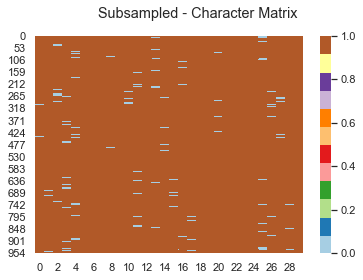

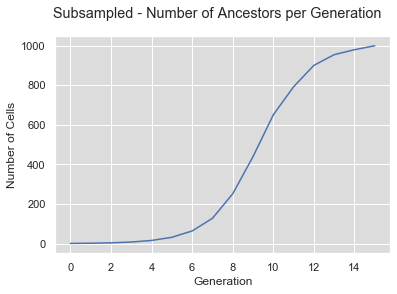

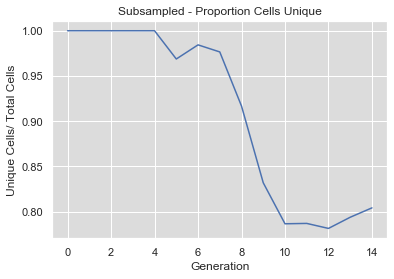

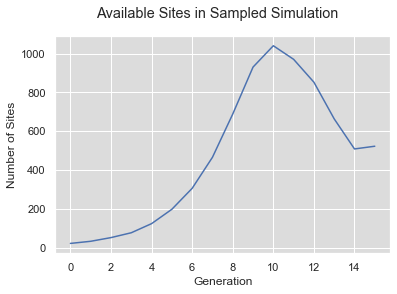

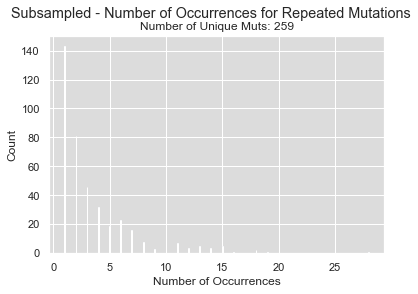

(1000, 30)
Time 1: 0.009509086608886719
Compute dictionary: 21.28247618675232
Conflict matrix is symmetric?  True
Total time: 21.298112154006958
Number of true recurrent muts:  409
Number of detected recurrent muts:  605
Number of true recurrent muts not detected: 9 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 2, 1000]


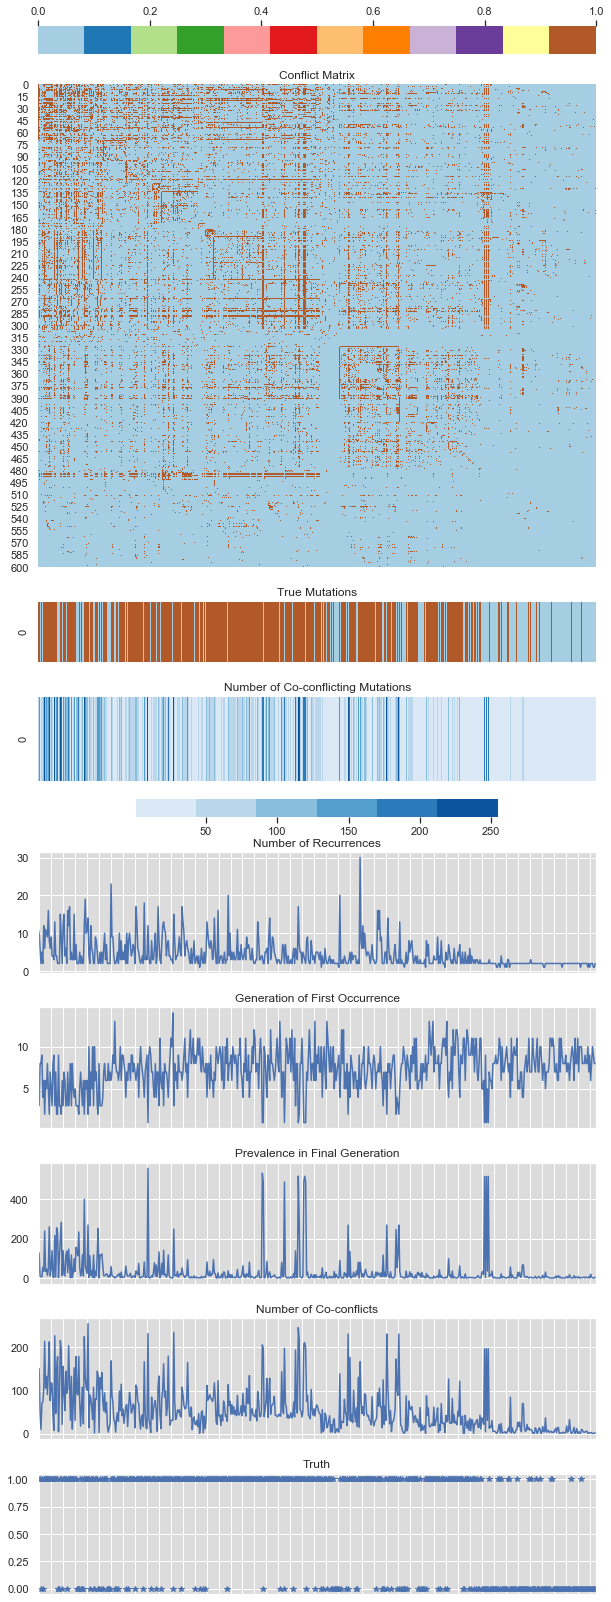

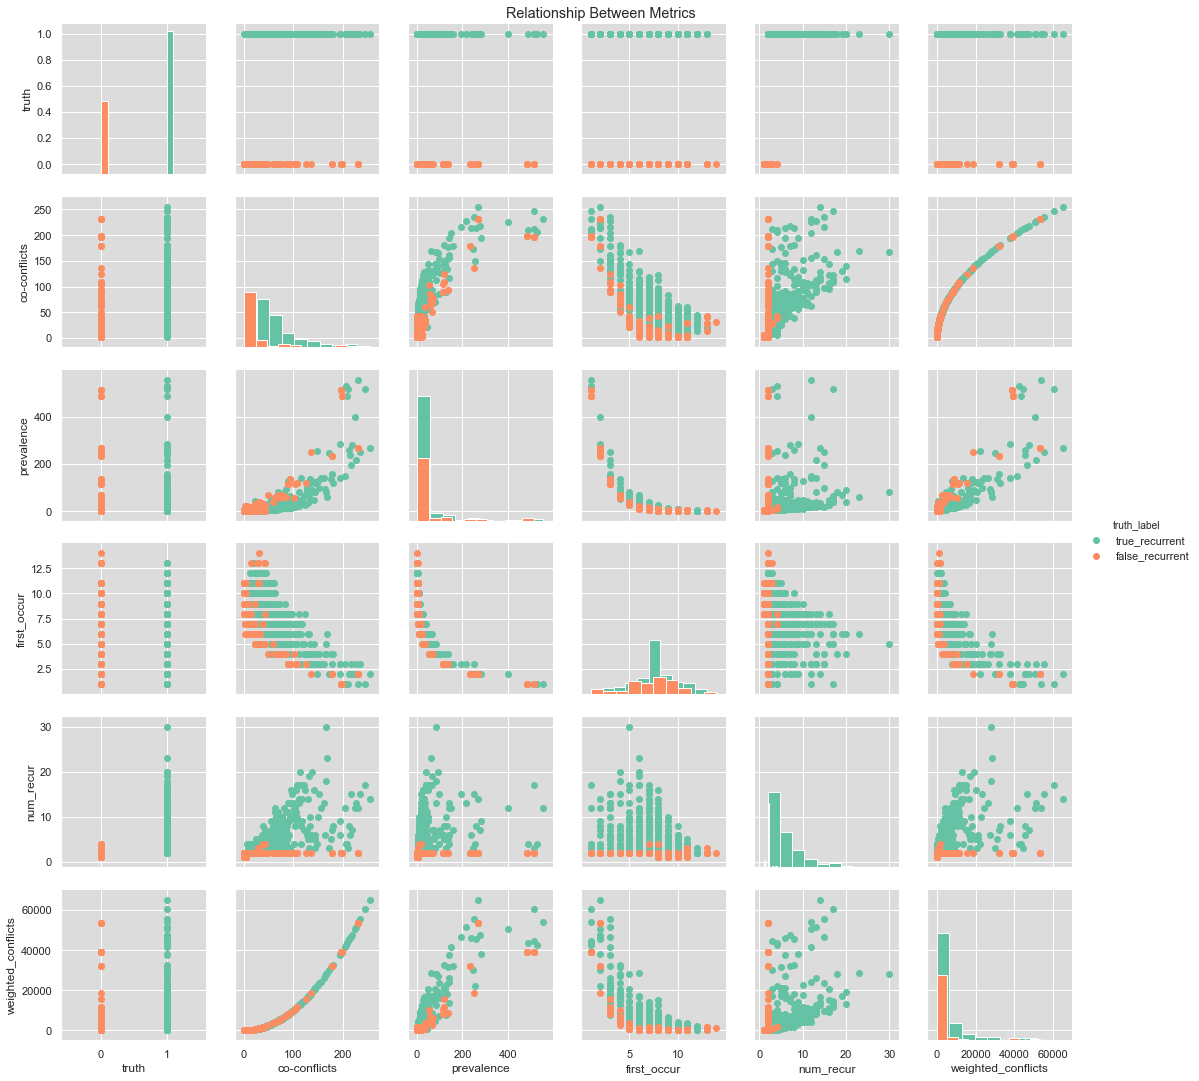

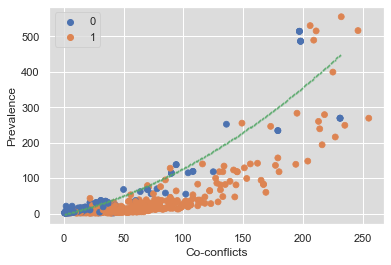

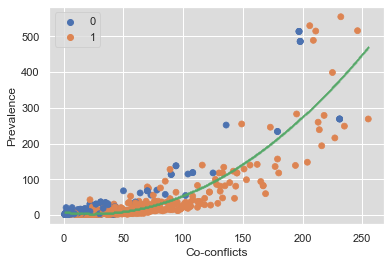

[    4    22    27    28    36    53    99   106   204   251   295   328
   366   387   395   415   439   482   496   591   598   644   663   696
   731   745   780   786   902   906   955  1002  1043  1130  1176  1187
  1193  1232  1242  1288  1297  1327  1357  1363  1402  1478  1499  1555
  1583  1589  1590  1607  1611  1656  1737  1747  1750  1780  1782  1820
  1852  1863  1887  1893  1952  2012  2016  2095  2097  2153  2163  2270
  2341  2393  2405  2407  2410  2424  2434  2443  2453  2480  2527  2646
  2667  2774  2790  2797  2866  2947  3047  3109  3145  3187  3224  3298
  3328  3441  3443  3533  3570  3626  3629  3728  3742  3788  3821  3844
  3868  3925  3931  3938  3952  3979  3986  4044  4056  4060  4066  4148
  4209  4214  4257  4262  4350  4374  4403  4413  4462  4549  4572  4625
  4631  4632  4692  4737  4761  4777  4797  4883  4987  5013  5116  5131
  5251  5282  5291  5295  5467  5580  5588  5614  5643  5660  5676  5698
  5800  5833  5857  5883  5937  5939  5941  5971  6

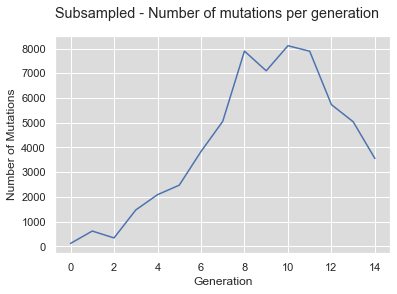

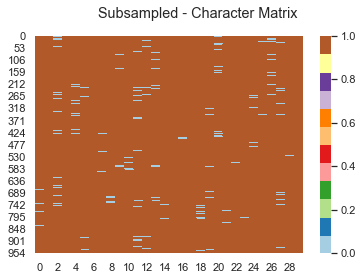

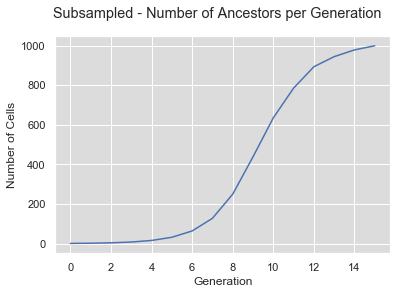

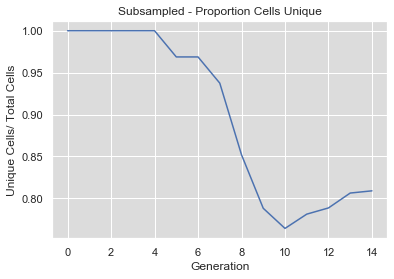

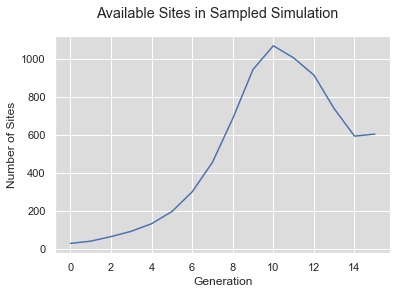

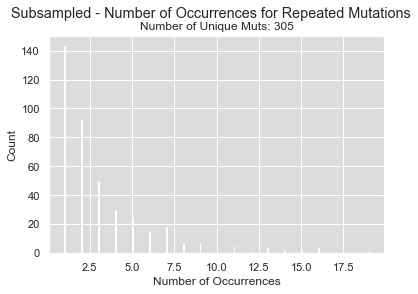

(1000, 30)
Time 1: 0.010684967041015625
Compute dictionary: 21.30506205558777
Conflict matrix is symmetric?  True
Total time: 21.32345700263977
Number of true recurrent muts:  414
Number of detected recurrent muts:  623
Number of true recurrent muts not detected: 3 with prevalence [1000, 1000, 1000]


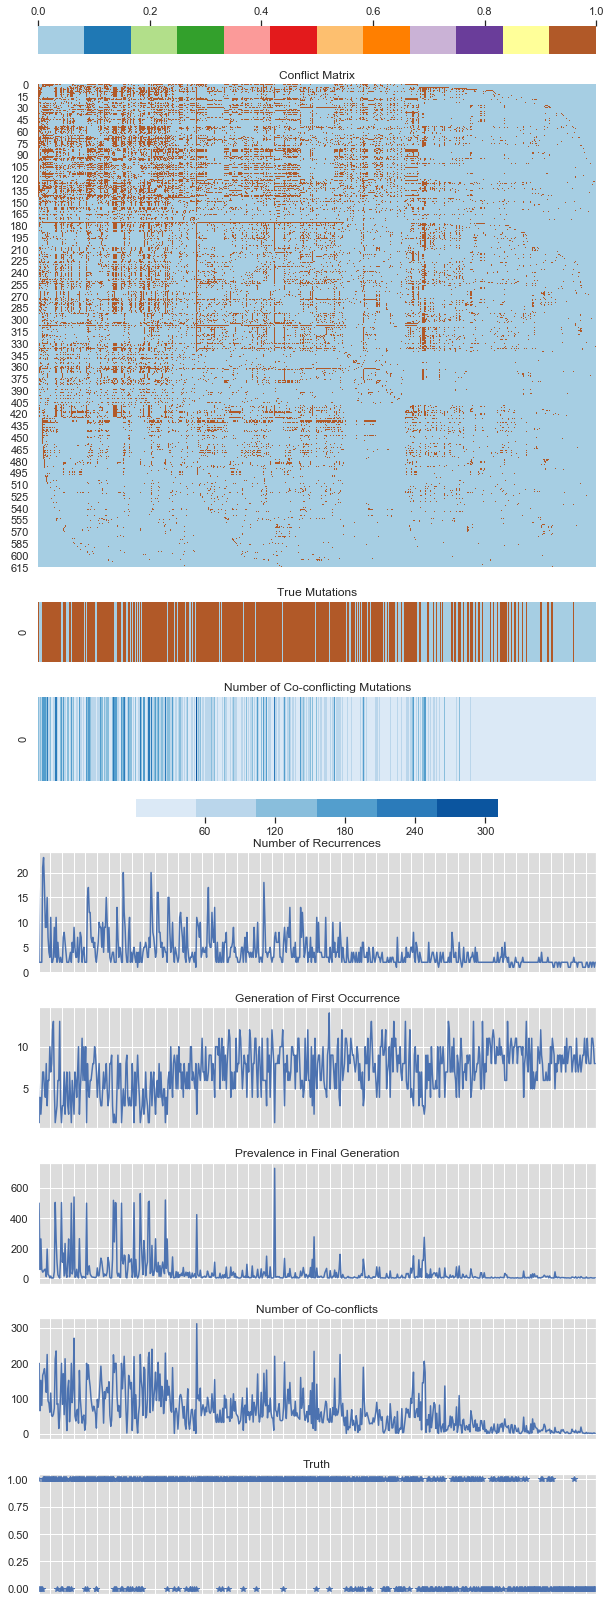

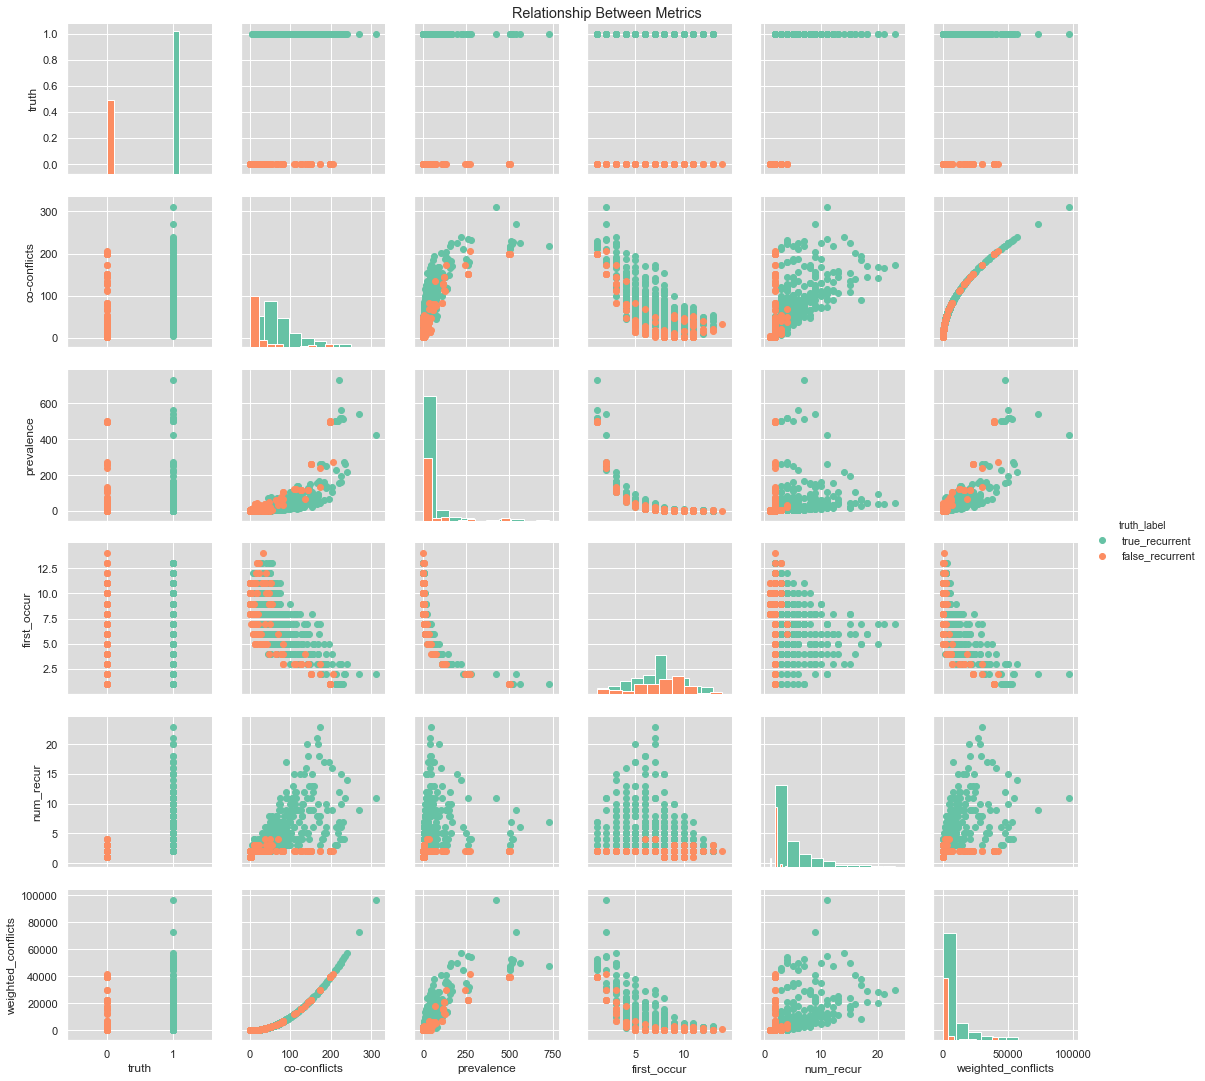

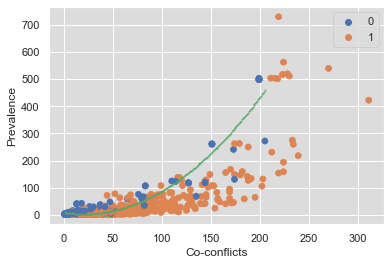

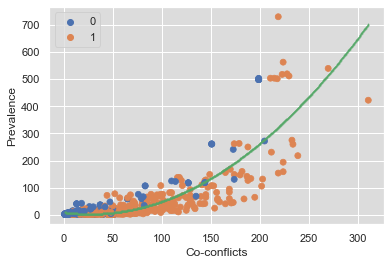

[   10    36    75    86   146   182   219   231   271   300   310   373
   394   423   439   462   474   503   516   530   536   538   588   596
   649   769   815   832   835   942   961   971  1011  1020  1022  1029
  1055  1142  1236  1261  1262  1384  1406  1413  1478  1544  1556  1653
  1671  1693  1748  1754  1762  1764  1779  1823  1908  1928  1931  1989
  2001  2003  2046  2064  2149  2156  2171  2194  2199  2242  2246  2294
  2316  2400  2413  2414  2421  2422  2424  2512  2536  2546  2569  2600
  2618  2629  2638  2658  2728  2746  2758  2877  2952  2957  2970  2984
  2998  3086  3133  3171  3186  3245  3255  3274  3303  3366  3424  3456
  3466  3515  3539  3549  3551  3557  3585  3648  3663  3711  3815  3825
  3868  3903  3927  3929  3968  3982  4019  4055  4069  4070  4116  4124
  4170  4223  4275  4296  4337  4349  4356  4423  4464  4469  4472  4510
  4560  4582  4594  4615  4689  4731  4740  4766  4788  4810  4830  4943
  4955  4984  5043  5070  5105  5122  5160  5198  5

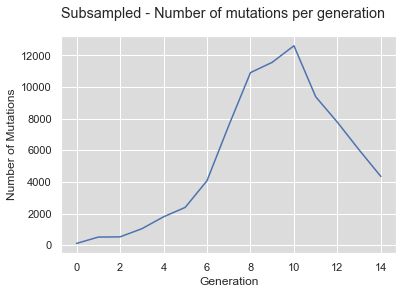

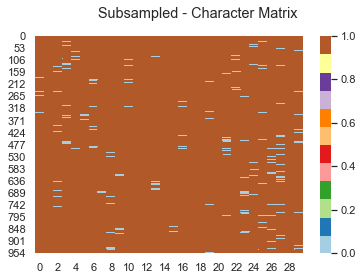

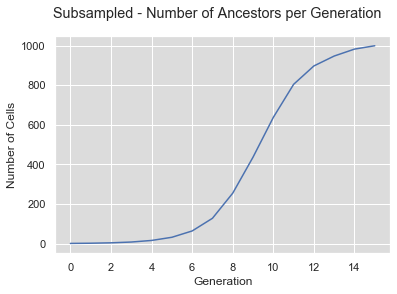

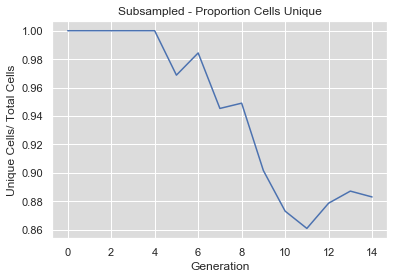

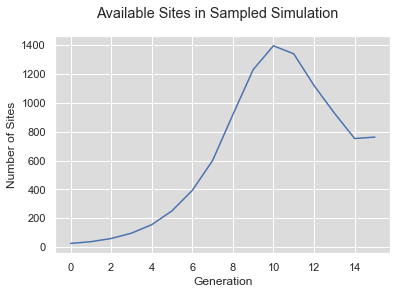

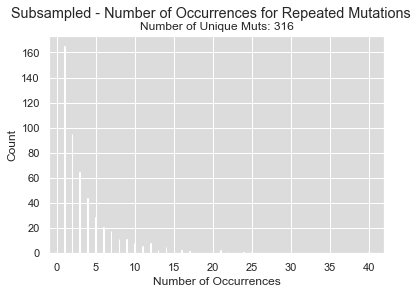

(1000, 30)
Time 1: 0.012171745300292969
Compute dictionary: 22.627543687820435
Conflict matrix is symmetric?  True
Total time: 22.651558876037598
Number of true recurrent muts:  505
Number of detected recurrent muts:  747
Number of true recurrent muts not detected: 5 with prevalence [1000, 1000, 1000, 1000, 1000]


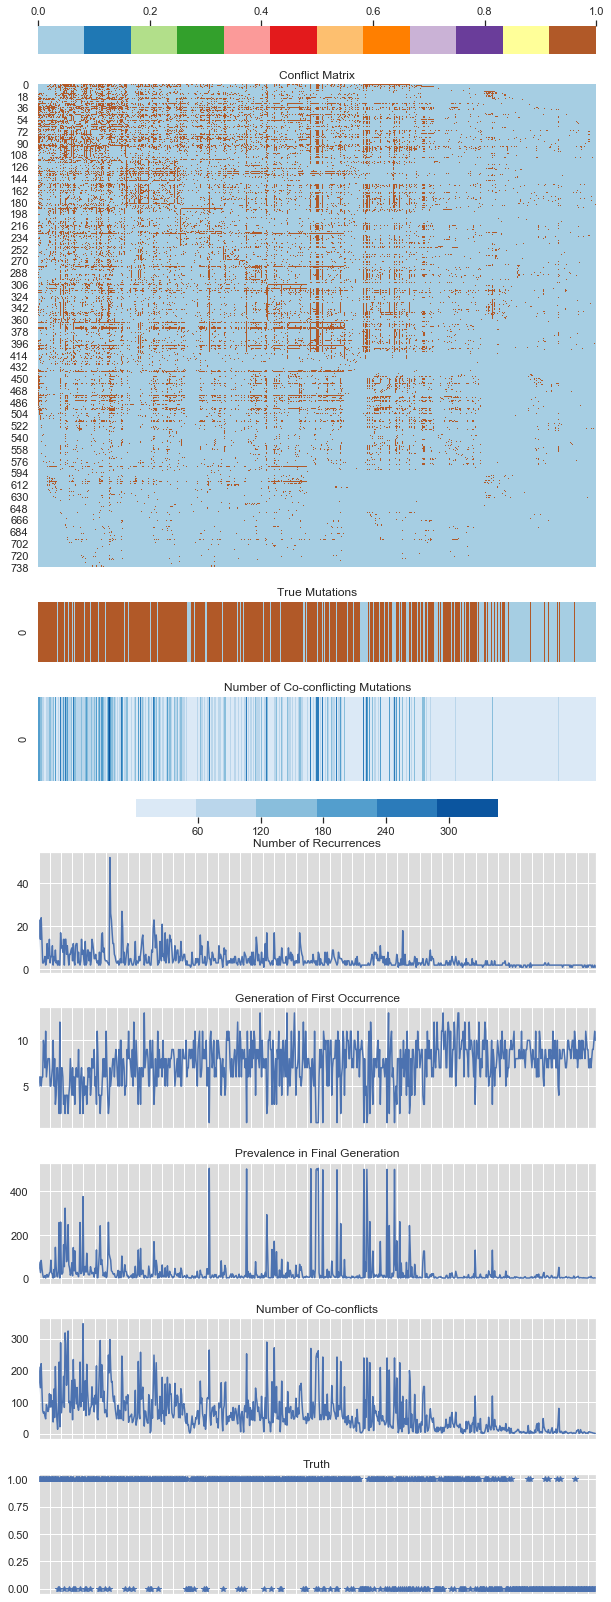

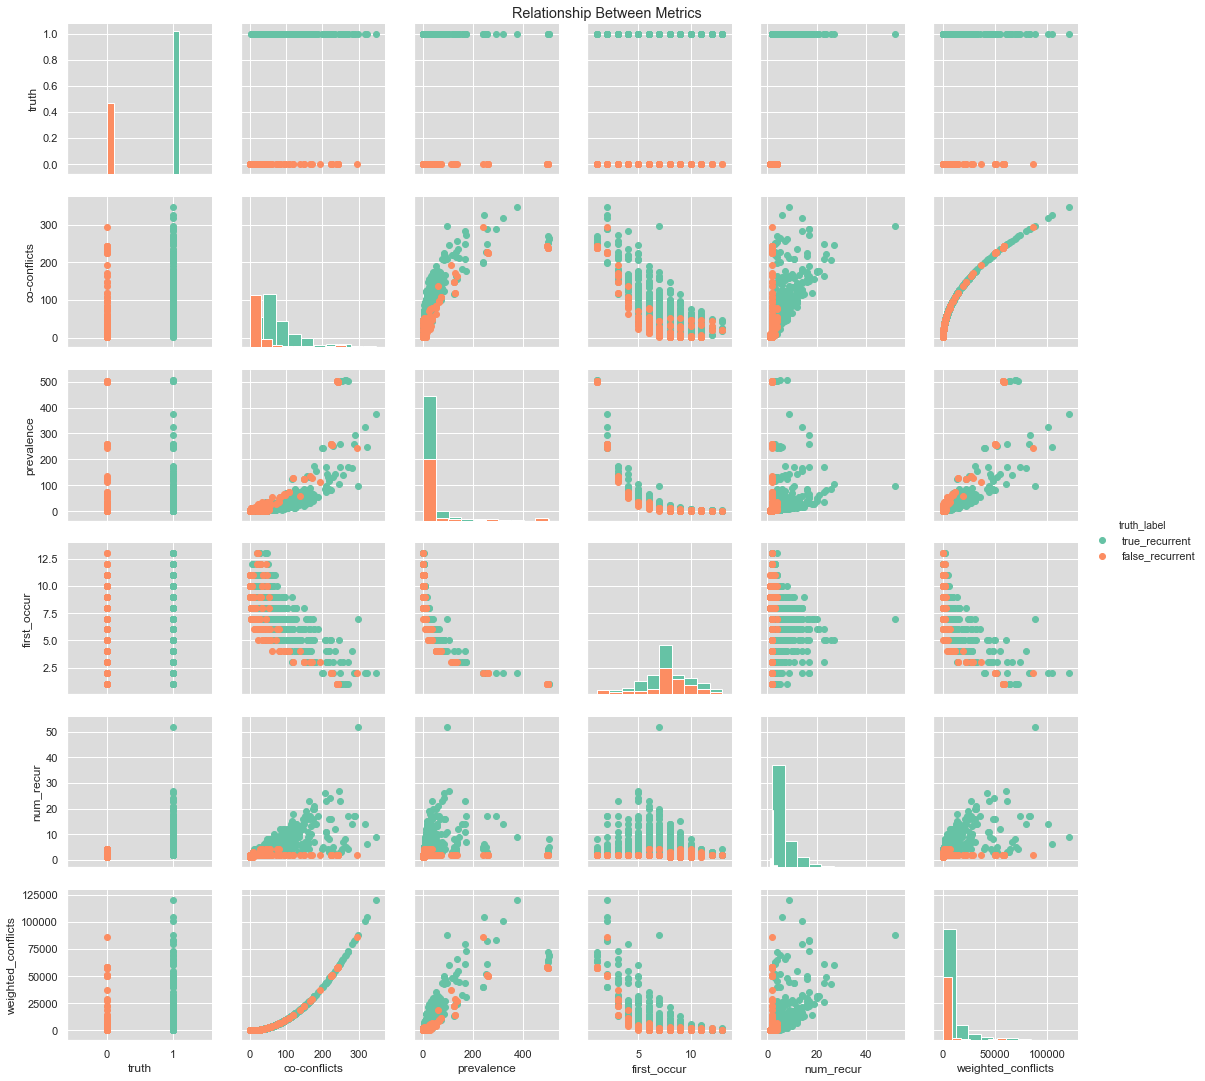

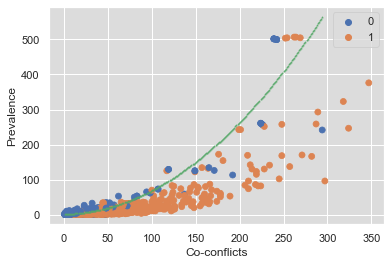

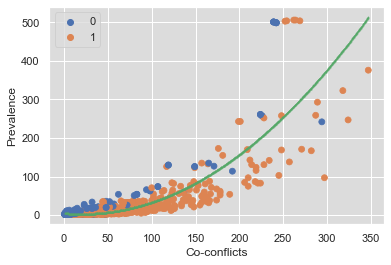

[   43    94   133   151   186   257   275   280   302   329   389   439
   481   495   510   529   546   558   610   637   731   765   810   811
   824   831   865   959   968   972   973   999  1008  1046  1113  1146
  1200  1238  1258  1291  1316  1341  1347  1350  1355  1391  1426  1447
  1485  1562  1574  1582  1592  1673  1682  1689  1713  1753  1770  1781
  1792  1821  1896  1941  1953  1980  2005  2145  2171  2183  2263  2269
  2331  2360  2418  2420  2470  2471  2513  2541  2606  2639  2653  2707
  2795  2808  2850  2863  2873  3011  3043  3110  3181  3187  3197  3282
  3344  3372  3376  3409  3433  3445  3475  3490  3602  3614  3665  3722
  3730  3760  3784  3858  3860  3864  3963  3976  3991  4016  4056  4116
  4138  4148  4152  4189  4206  4244  4245  4262  4271  4273  4280  4334
  4406  4449  4502  4555  4563  4587  4656  4784  4811  4819  4852  4929
  4932  5014  5034  5054  5086  5124  5131  5135  5192  5221  5226  5278
  5279  5305  5338  5340  5360  5420  5439  5441  5

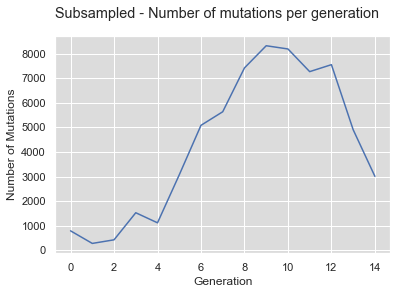

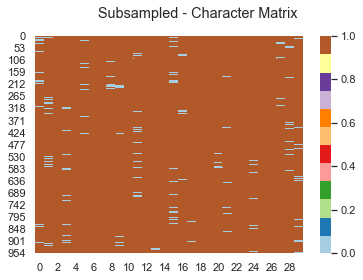

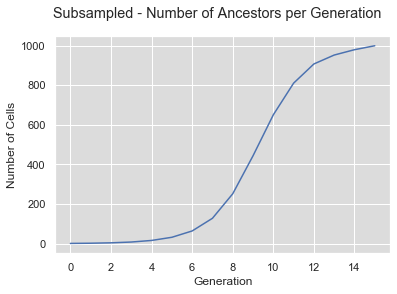

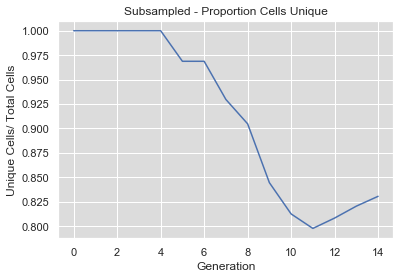

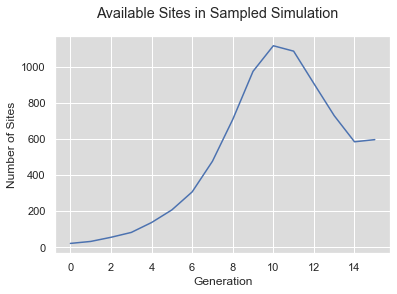

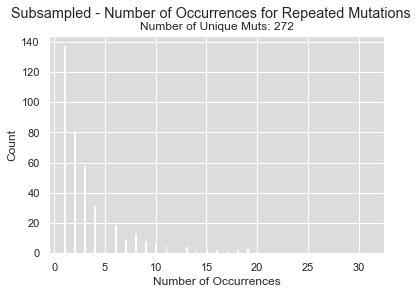

(1000, 30)
Time 1: 0.010740041732788086
Compute dictionary: 23.405416011810303
Conflict matrix is symmetric?  True
Total time: 23.42474603652954
Number of true recurrent muts:  415
Number of detected recurrent muts:  603
Number of true recurrent muts not detected: 9 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2]


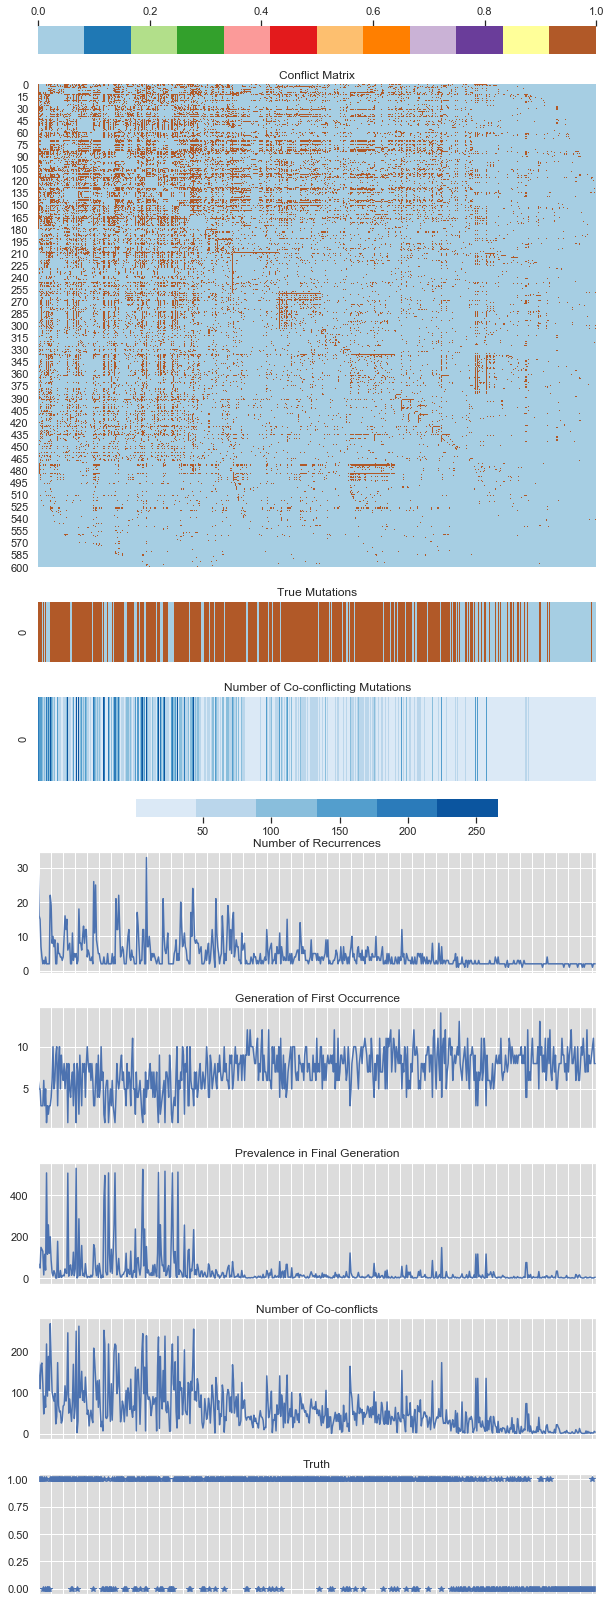

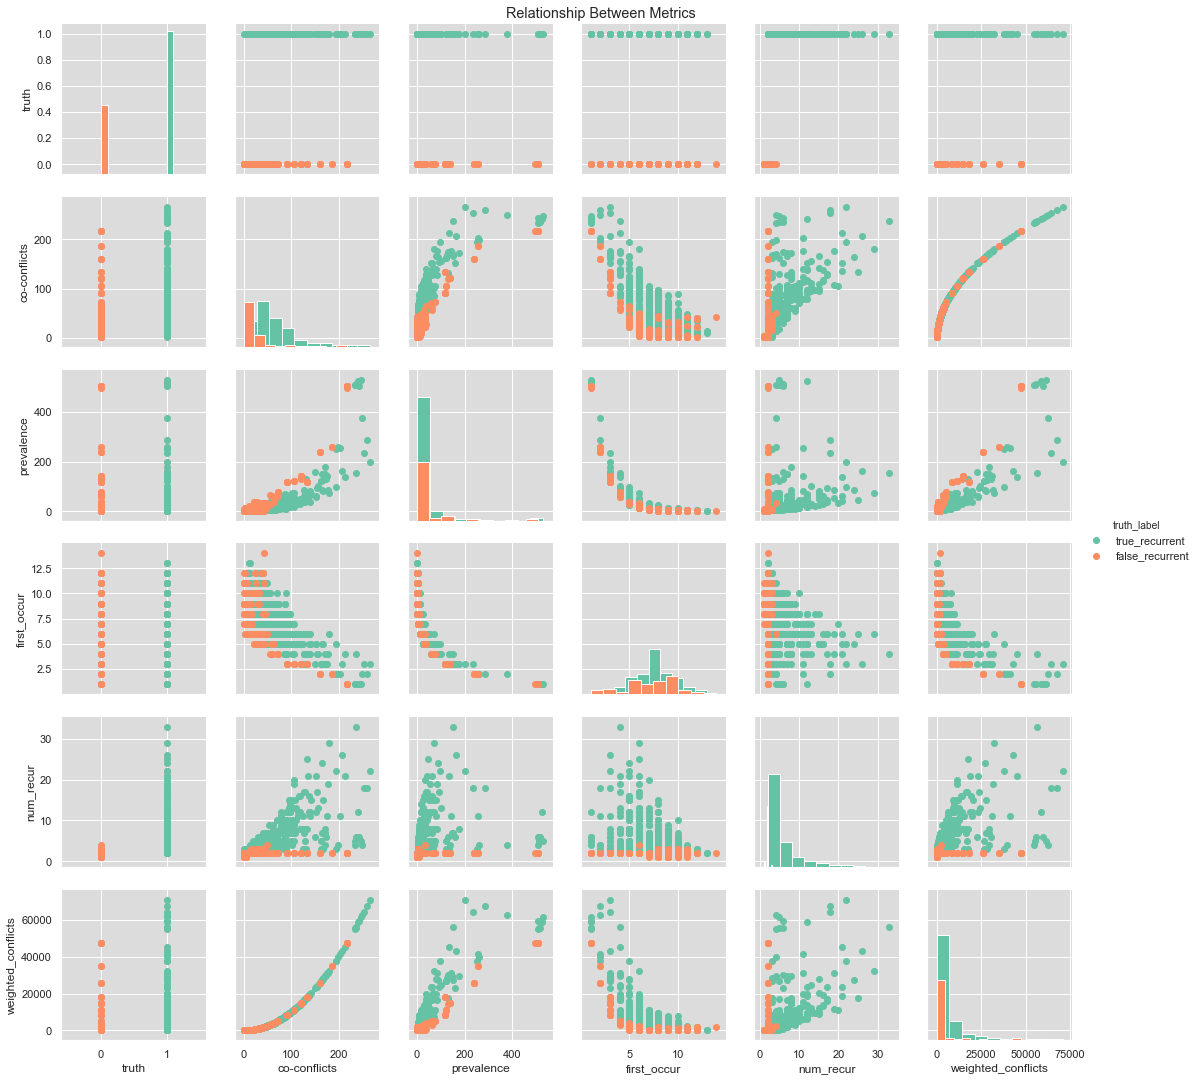

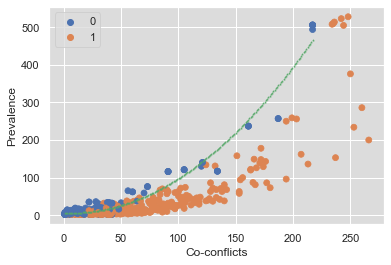

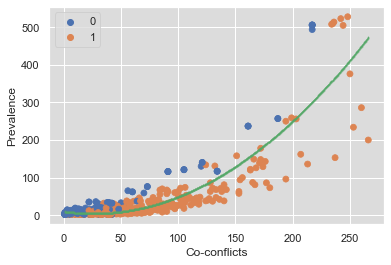

[    4    75    86   153   193   239   266   310   413   442   498   521
   531   573   583   640   653   667   672   675   680   734   788   794
   795   808   885   895   940   942   947   970   976  1028  1029  1056
  1095  1129  1152  1164  1174  1195  1272  1303  1313  1324  1327  1416
  1431  1439  1442  1511  1528  1566  1578  1609  1659  1710  1826  1868
  1948  1953  1988  1994  2012  2038  2075  2096  2113  2141  2200  2253
  2277  2293  2302  2321  2350  2366  2383  2418  2431  2461  2512  2590
  2608  2617  2707  2765  2781  2785  2799  2903  2945  2961  2979  2997
  3048  3049  3118  3120  3139  3153  3171  3176  3201  3213  3248  3251
  3268  3290  3326  3383  3394  3420  3451  3460  3493  3506  3533  3562
  3587  3594  3599  3629  3648  3663  3720  3793  3854  3925  3927  3946
  4025  4086  4088  4127  4129  4133  4158  4159  4200  4201  4249  4309
  4321  4392  4420  4428  4468  4498  4559  4566  4588  4621  4657  4665
  4697  4725  4728  4814  4874  4925  5024  5047  5

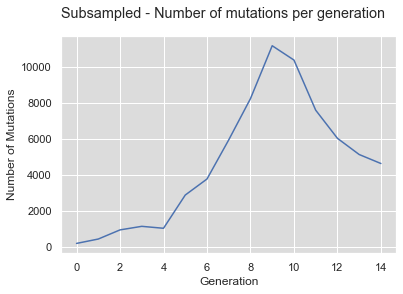

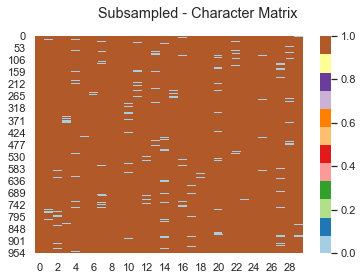

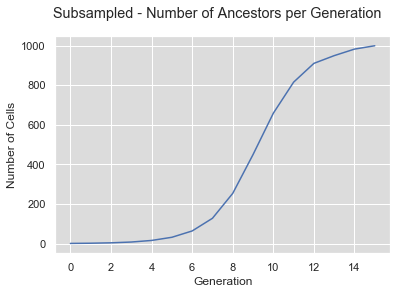

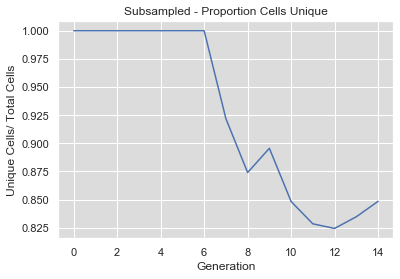

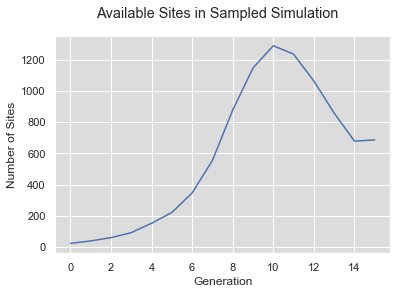

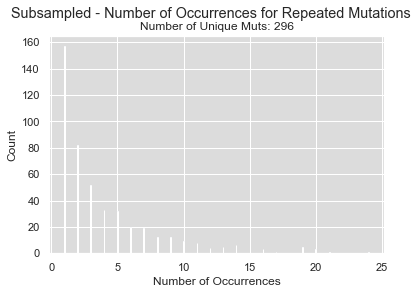

(1000, 30)
Time 1: 0.012592792510986328
Compute dictionary: 29.743621826171875
Conflict matrix is symmetric?  True
Total time: 29.77676296234131
Number of true recurrent muts:  467
Number of detected recurrent muts:  685
Number of true recurrent muts not detected: 5 with prevalence [1000, 1000, 1000, 1000, 1000]


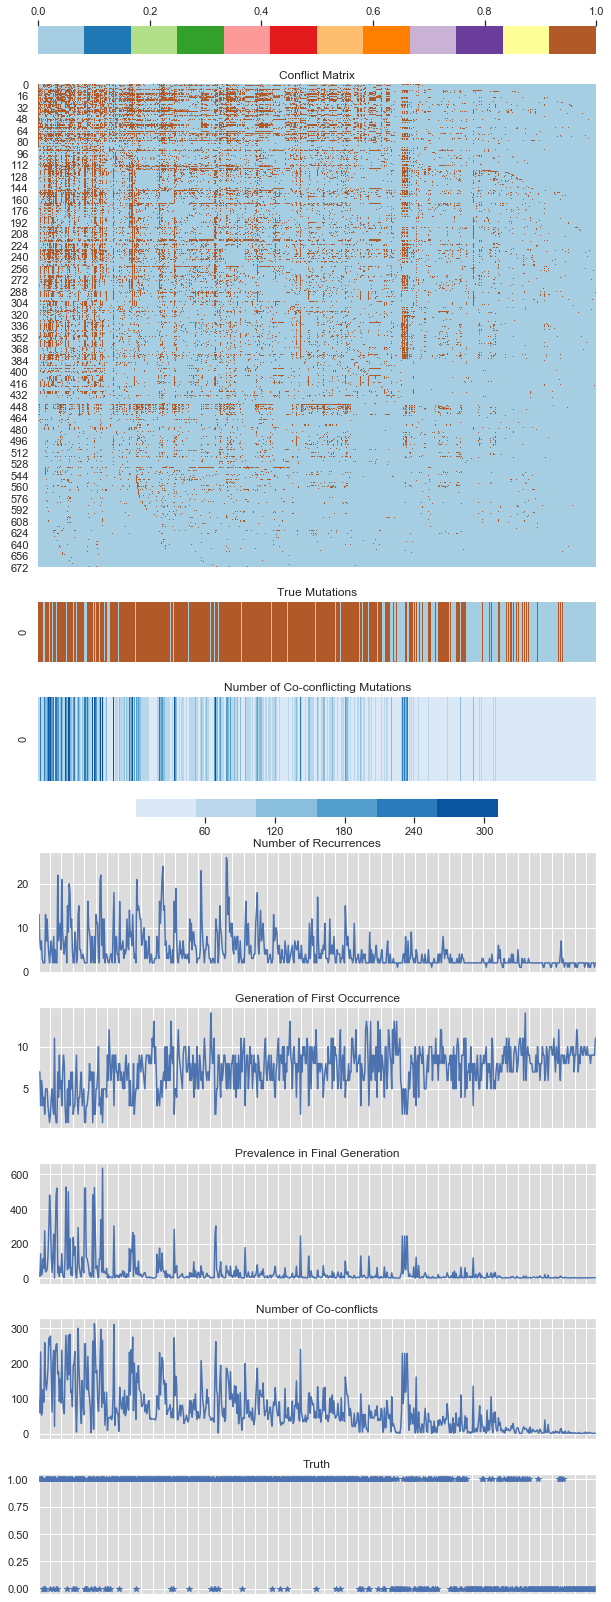

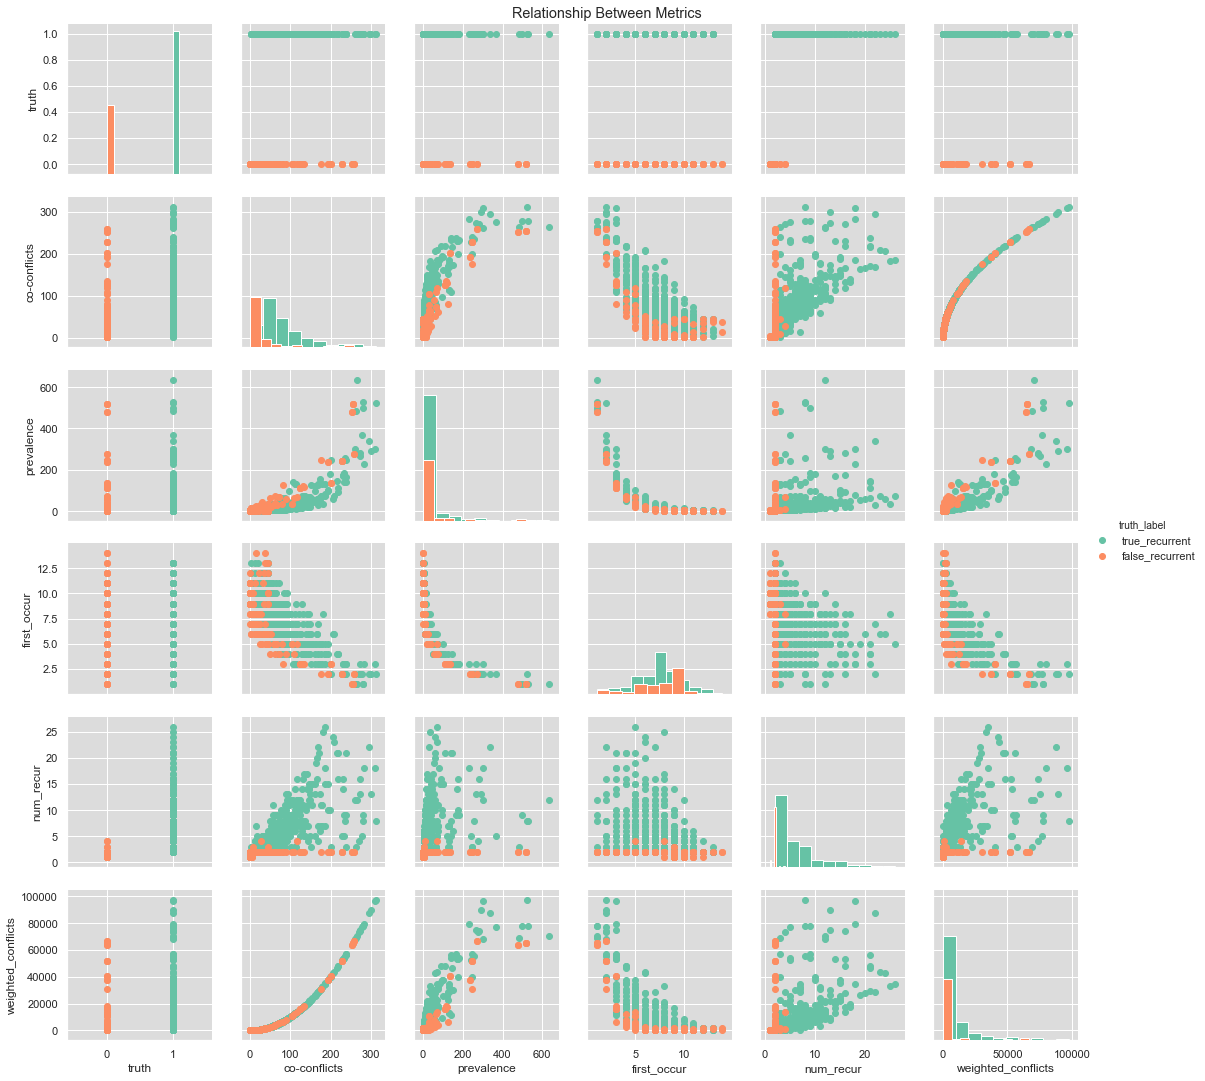

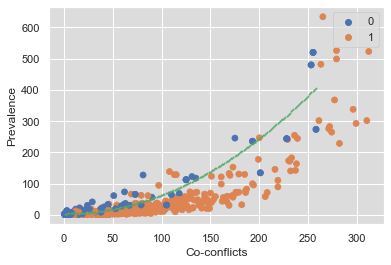

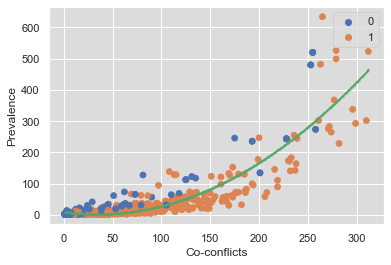

[    2     3    16    18   103   147   199   217   231   281   295   336
   387   416   421   426   446   458   538   553   600   648   680   716
   848   875   883   893   897   948   952   980   995   997  1032  1045
  1075  1079  1123  1136  1213  1286  1306  1320  1322  1443  1497  1499
  1501  1566  1580  1676  1698  1716  1736  1776  1799  1809  1846  1906
  1913  1919  1993  2198  2203  2229  2244  2248  2298  2354  2393  2417
  2432  2483  2519  2599  2604  2619  2647  2683  2842  2893  2955  2991
  3026  3097  3111  3151  3209  3215  3263  3300  3334  3345  3376  3463
  3467  3507  3537  3715  3729  3745  3749  3768  3887  3917  3924  3980
  4005  4021  4058  4085  4108  4127  4155  4226  4236  4238  4241  4247
  4292  4303  4305  4307  4358  4385  4393  4431  4450  4497  4520  4523
  4532  4537  4588  4608  4623  4640  4679  4722  4747  4752  4767  4854
  4918  4926  4954  4966  4969  5004  5047  5168  5193  5233  5266  5288
  5369  5384  5387  5437  5505  5513  5554  5590  5

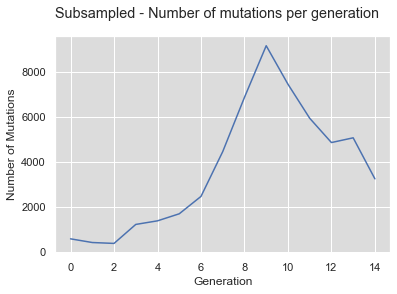

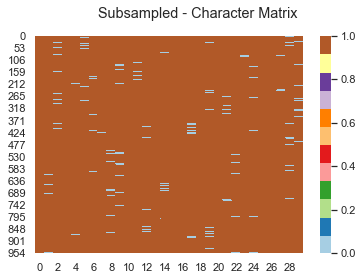

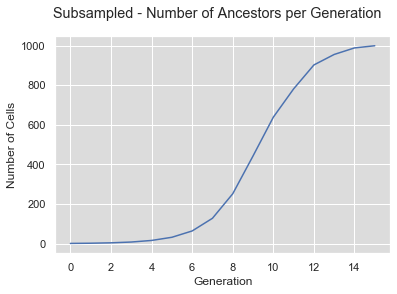

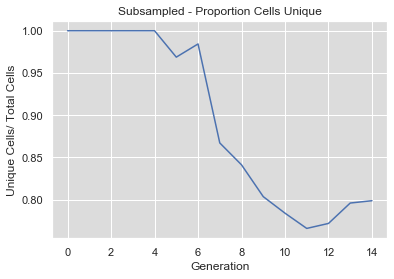

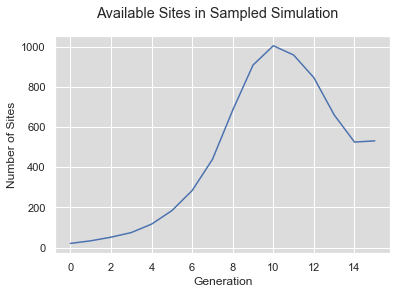

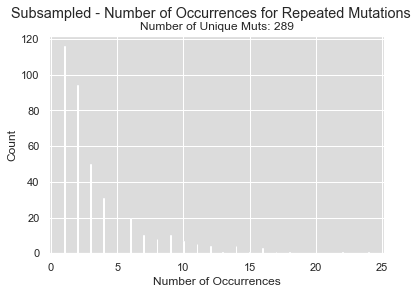

(1000, 30)
Time 1: 0.010991096496582031
Compute dictionary: 22.280193090438843
Conflict matrix is symmetric?  True
Total time: 22.296329975128174
Number of true recurrent muts:  389
Number of detected recurrent muts:  561
Number of true recurrent muts not detected: 10 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2]


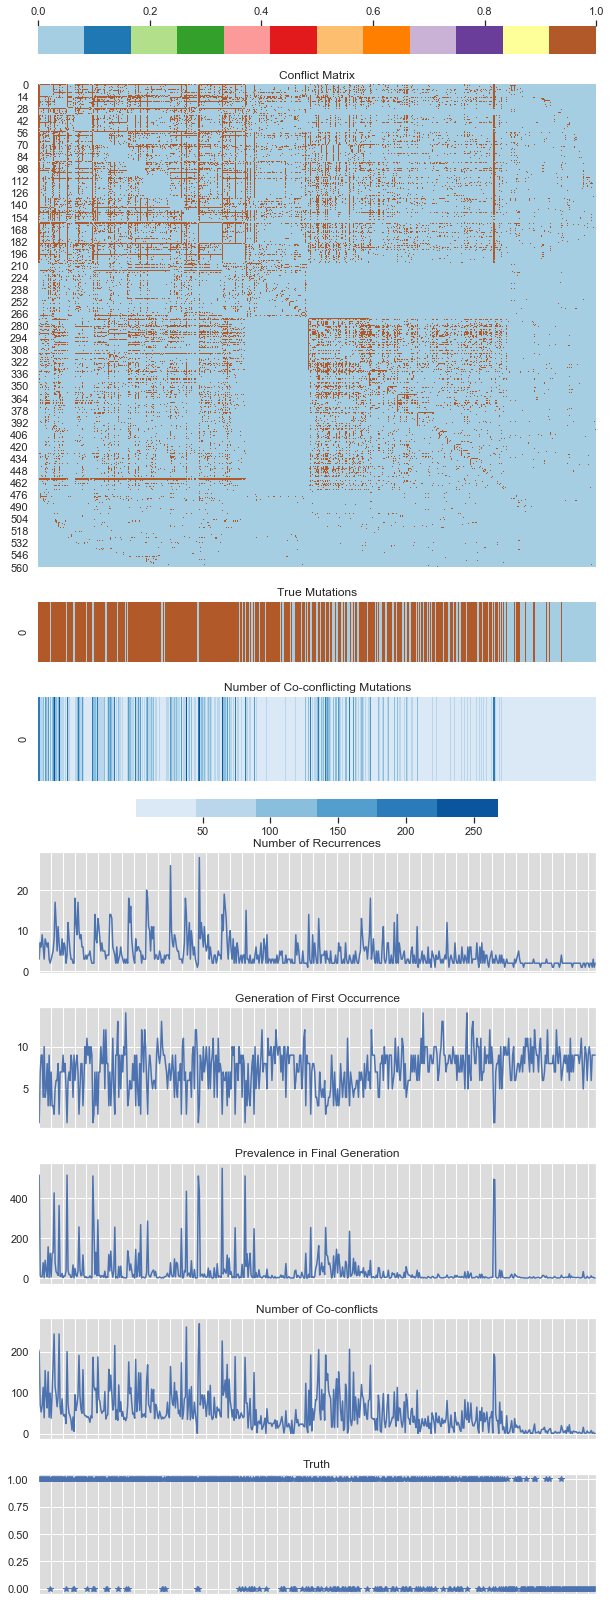

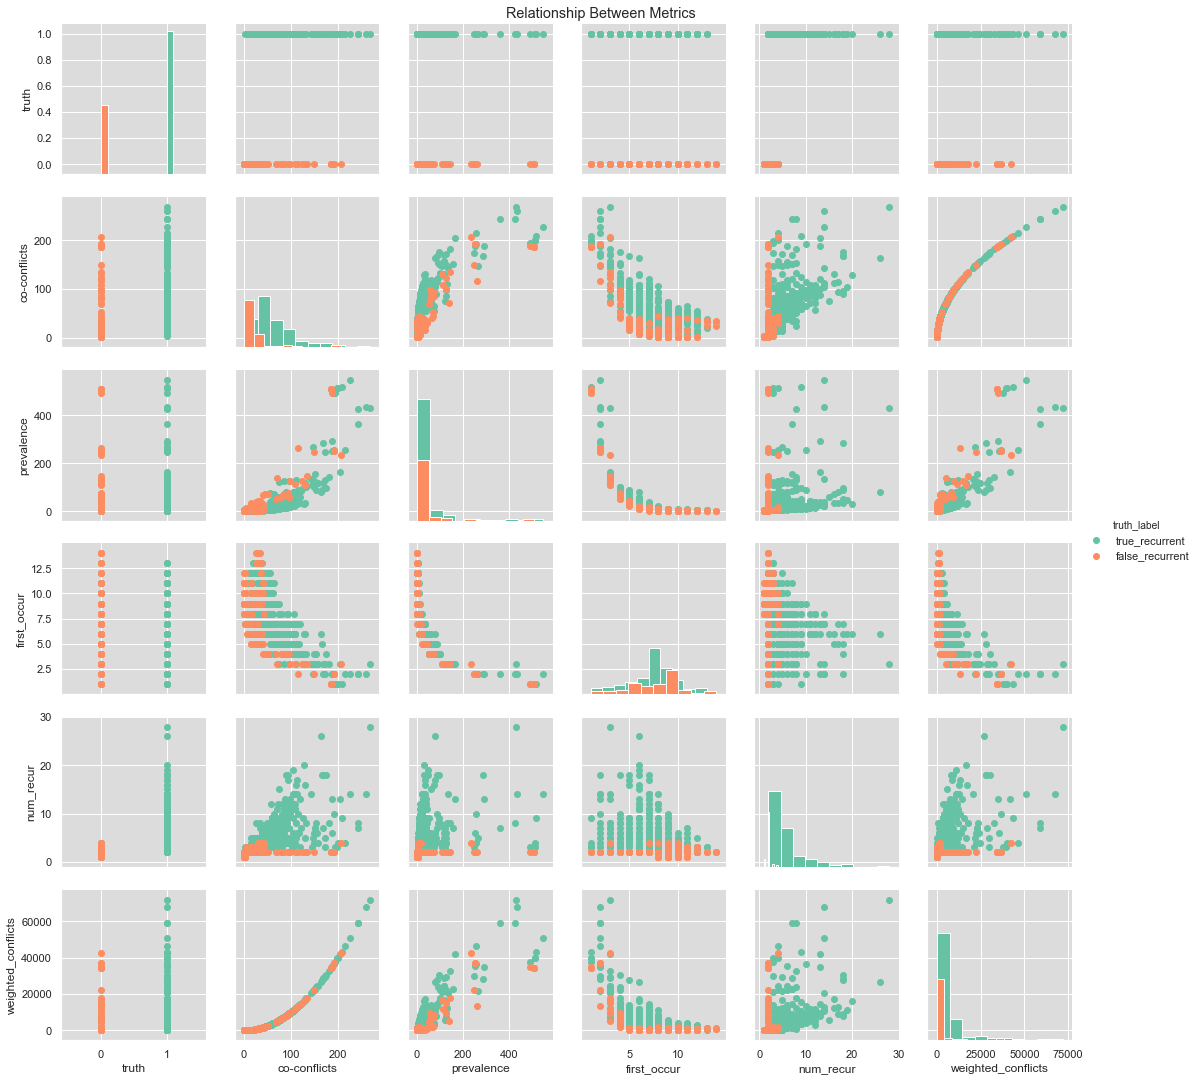

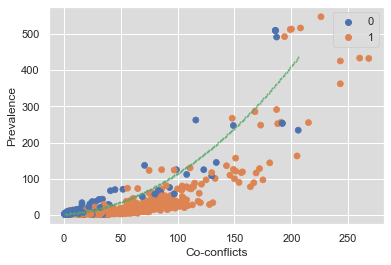

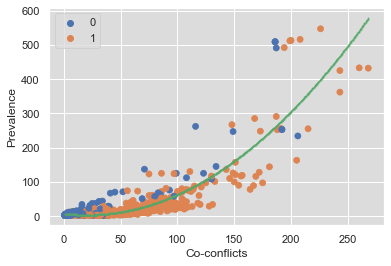

[   39    47   165   369   424   431   457   498   537   685   719   757
   761   789   874   903   916   955   997  1095  1197  1212  1221  1308
  1353  1401  1410  1439  1477  1496  1507  1526  1534  1548  1573  1687
  1703  1790  1811  1845  1926  2010  2034  2123  2128  2178  2213  2305
  2317  2334  2382  2414  2458  2463  2503  2509  2545  2564  2597  2602
  2633  2670  2683  2727  2801  2805  2818  2820  2874  2875  2885  2901
  2919  2932  2937  2941  2956  3011  3067  3070  3092  3103  3104  3139
  3218  3222  3230  3262  3358  3372  3386  3400  3415  3431  3487  3541
  3556  3577  3646  3660  3768  3801  3833  3843  3851  3917  3925  3926
  3929  3958  3994  4044  4098  4106  4131  4179  4186  4202  4213  4226
  4227  4261  4303  4319  4365  4383  4385  4436  4445  4553  4566  4679
  4704  4706  4734  4755  4768  4812  4851  4854  4892  4917  4932  4934
  5002  5067  5093  5111  5218  5232  5273  5388  5452  5461  5497  5629
  5631  5655  5700  5813  5823  5952  5958  5980  6

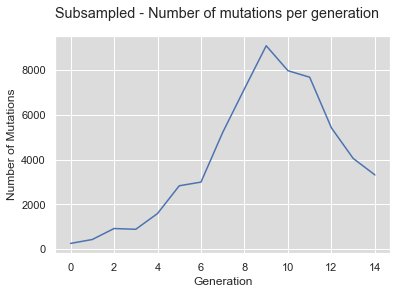

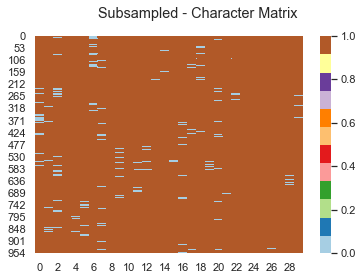

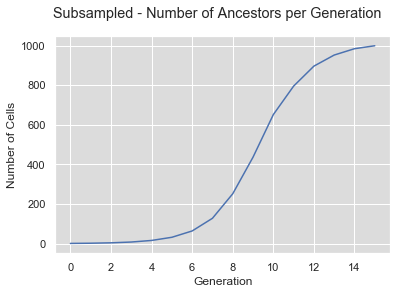

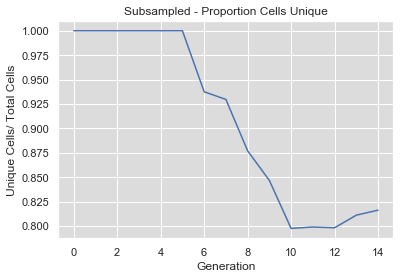

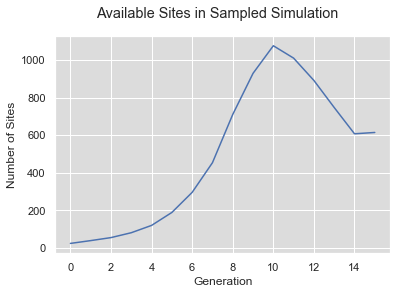

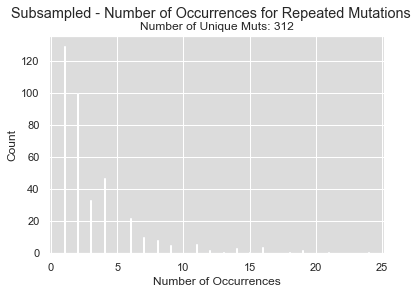

(1000, 30)
Time 1: 0.010714054107666016
Compute dictionary: 27.951550006866455
Conflict matrix is symmetric?  True
Total time: 27.96978783607483
Number of true recurrent muts:  401
Number of detected recurrent muts:  614
Number of true recurrent muts not detected: 7 with prevalence [1000, 1000, 1000, 1000, 4, 1000, 1000]


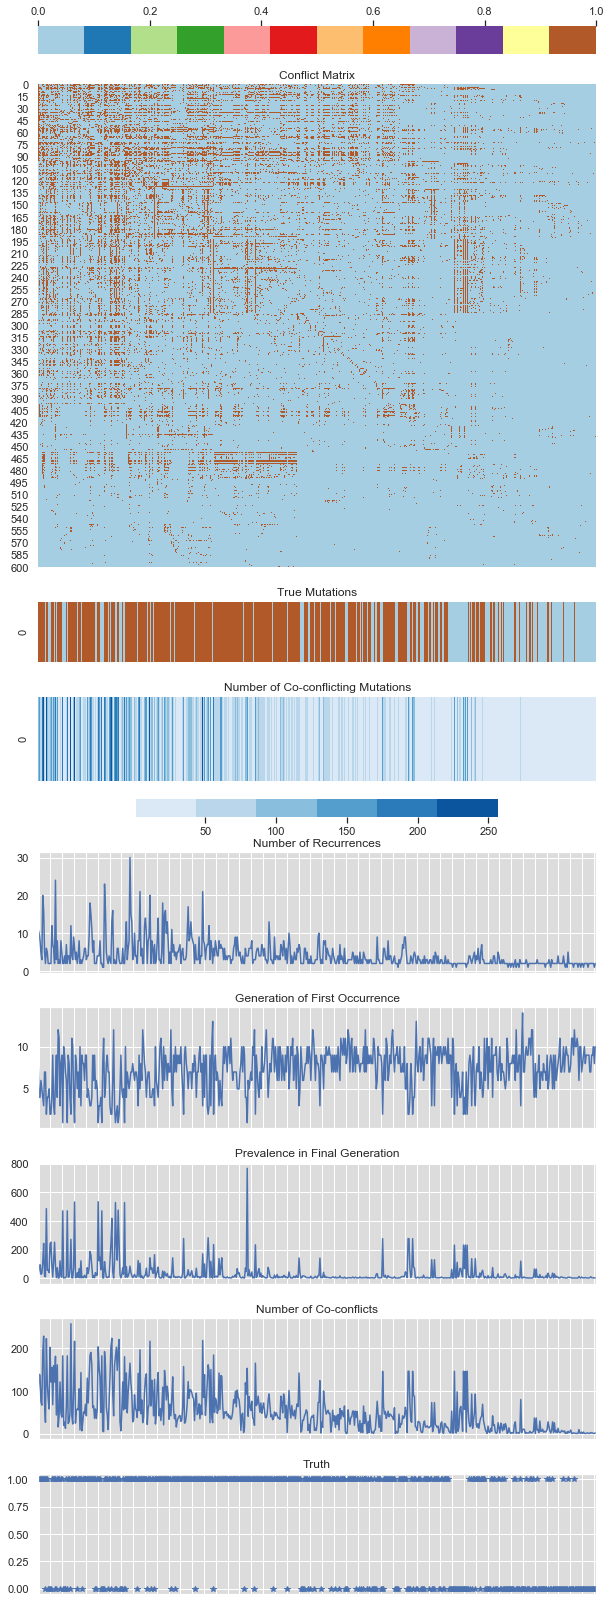

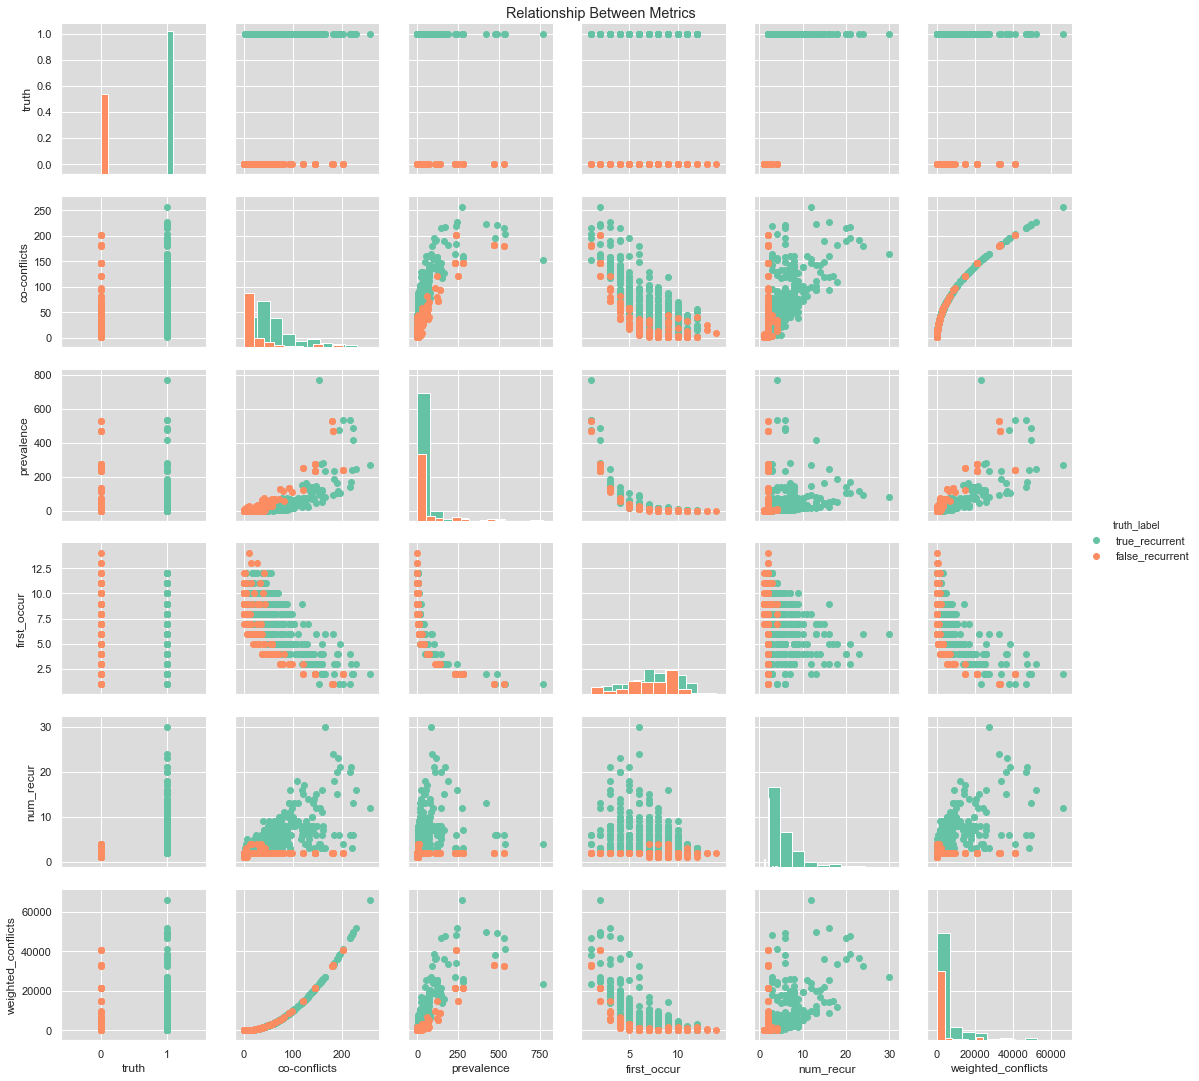

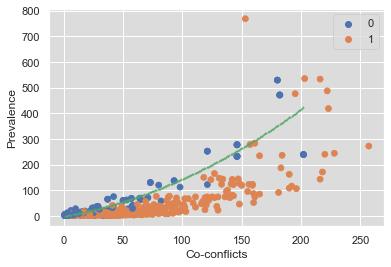

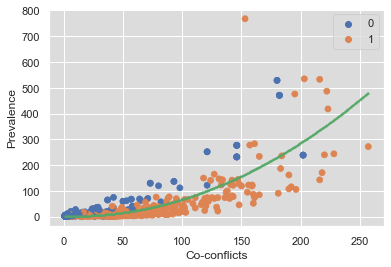

In [7]:
simulation_list = []

for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)

    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
        
    deletions_probs = pd.DataFrame(deletions)
    deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)

    deletions_probs = deletions_probs[:, :100]
    deletions_probs /= deletions_probs.sum(1, keepdims=True)
    
    edit_probs = np.hstack([mutation_probs.reshape(-1,1), (1-mutation_probs.reshape(-1,1))*deletions_probs.numpy()])
    
    
    
    for init_cells in init_cell_list:

        for run in range(num_runs):
            
            simulation = lineageSimulationFast(label, tree_depth, 
                                           num_edit_sites, deletions_probs, 
                                           mutation_probs, edit_probs, init_cells=init_cells, n_subsample=n_subsample)

            try:
                # Summarize results
                # Plot a regression for the non-recurrent mutations
                X = simulation.conflict_matrix.sum(0)
                Y = simulation.prevalence_tape
                ix = np.array(simulation.truth_tape)==0

        #         from sklearn.linear_model import LinearRegression
        #         reg = LinearRegression().fit(X[ix].reshape(-1,1), Y[ix].reshape(-1,1))

                x = X[ix]
                y = Y[ix]

                new_x = np.linspace(min(x), max(x), num=np.size(x))
                coefs = np.polyfit(x,y,2)
                new_line = np.polyval(coefs, new_x)

                plt.figure()
                sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                                cmap='Paired', edgecolor=None,)

                plt.scatter(new_x,new_line,c='g', marker='^', s=1)
                plt.xlabel('Co-conflicts')
                plt.ylabel('Prevalence')
                plt.show()
                plt.close()

                simulation.random_attr['coef'] = coefs


                simulation.random_attr['num_conflict'] = simulation.conflict_matrix.shape[0]

                x = X
                y = Y

                new_x = np.linspace(min(x), max(x), num=np.size(x))
                coefs = np.polyfit(x,y,2)
                new_line = np.polyval(coefs, new_x)

                plt.figure()
                sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                                cmap='Paired', edgecolor=None,)

                plt.scatter(new_x,new_line,c='g', marker='^', s=1)
                plt.xlabel('Co-conflicts')
                plt.ylabel('Prevalence')
                plt.show()
                plt.close()

                simulation.random_attr['full_reg_coef'] = coefs

                simulation_list.append(simulation)
            except:
                print('Recurrent mutations not identified.')


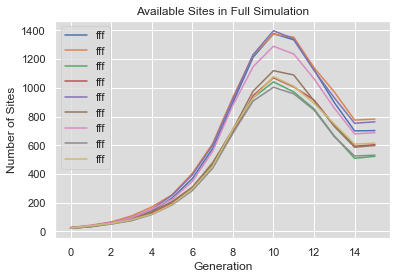

In [8]:
# Plot available sites in full simulation
plt.figure()
for simulation in simulation_list:
    plt.plot(simulation.open_sites, label=simulation.label)
plt.title('Available Sites in Full Simulation')
plt.xlabel('Generation')
plt.ylabel('Number of Sites')
plt.legend()
plt.show()
plt.close()

## Tree Reconstruction - NJ

In [9]:
def compare(simulation, entries=None):
    from scipy.spatial.distance import pdist, squareform

    if entries is None:
        entries = simulation.feature_matrix.index.values
    entries = list(reversed(entries))
    x = []
    for e in entries:
        if e < simulation.feature_matrix.shape[0]:
            x.append(simulation.feature_matrix.iloc[e].values)
        else:
            x.append(simulation.random_attr['steps']['lcas'][e])

    
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    fig = make_subplots(rows=2, cols=1, subplot_titles=("Character Matrix", "P(Indel)"), row_heights=[0.9,0.1], shared_xaxes=True)

    fig.append_trace(go.Heatmap(z=x,  colorscale = 'gray', y=['node-'+str(t) for t in entries]), row=1, col=1)
    fig.append_trace(go.Heatmap(z=[simulation.random_attr['prob_indels'].reshape(-1)]), row=2, col=1)

    fig.update_layout(height=800, width=1000, title_text="Comparison of Accumulated Indels")
    fig.show()

    # Also show a heatmap of the distances (with and without log probs) 
    logD = pdist(x, lambda u,v: (- (u + v - 2*u*v) * np.log(simulation.random_attr['prob_indels'].reshape(-1))).sum())
    
    plt.figure(figsize=(10,10))
    sns.heatmap(squareform(logD), yticklabels=entries,cmap='coolwarm')
    plt.title('Logprob distance between nodes')
    plt.show()
    plt.close()
    
    D = pdist(x, 'hamming')
    
    plt.figure(figsize=(10,10))
    sns.heatmap(squareform(D), yticklabels=entries,cmap='coolwarm')
    plt.title('Hamming distance between nodes')
    plt.show()
    plt.close()
    
    return logD, D, entries


def compute_accuracy(r1, r2):
        t1, t2 = [], []
        t1_labels, t2_labels = [], []

        r1_kids, r2_kids = [None, None],  [None, None]
        for i, child in enumerate(r1.children):
            leaves = [x.name for x in child.tips()] 
            t1 += leaves
            t1_labels += [i]*len(leaves)
            r1_kids[i] = child

        r1_kids = [None, None]
        for i, child in enumerate(r2.children):
            leaves = [x.name for x in child.tips()] 
            t2 += leaves
            t2_labels += [i]*len(leaves)
            r2_kids[i] = child

        t1_true = dict(zip(t1, t1_labels))
        t2_true = dict(zip(t2, t2_labels))

        acc = 0
        for n in t1:
            acc += (t1_true[n] == t2_true[n])

        acc /= len(t1)
        if acc < 0.5:
            return 1-acc, r1_kids, list(reversed(r2_kids))
        else:
            return acc, r1_kids, r2_kids

def tips(node):
    if node is None:
        return []
    else:
        return [x.name for x in node.tips()]

def why_are_trees_bad(simulation, mod_tree, steps):
    
    r1 = simulation.true_tree.root()
    r2 = mod_tree.root()

    # Go breadth-first down the tree 
    queue1 = [r1]
    queue2 = [r2]


    next_queue1 = []
    next_queue2 = []


    level = 0 
    for i in range(10):

        next_queue1 = [None]*(2*len(queue1))
        next_queue2 = [None]*(2*len(queue1))

        level += 1 
        print('----------------------------------------------------')
        print('Level: {0}'.format(level))
        print(len(queue1))
        for i, r1 in enumerate(queue1):
            r2 = queue2[i]


            # Check how good the split is at this level: 

            if r1 and r2:
                acc, r1_children, r2_children = compute_accuracy(r1, r2)

                print('Accuracy:', acc)
            else:
                print('r1 or r2 is None')


            if acc < 1:

                lcas = pd.DataFrame([steps['lcas'][int(r2.children[1].name)], steps['lcas'][int(r2.children[0].name)]])
                lcas.columns = simulation.feature_matrix.columns 

                num_sites = simulation.cell_record[0].shape[1]
                original = []
                for site_num in range(num_sites):
                    x = simulation.feature_matrix.columns[simulation.feature_matrix.columns<(site_num+1)*1000]
                    x = x[x>site_num*1000]

                    original.append((lcas[x]*(x-site_num*1000)).sum(1).values)

                original = np.array(original).T    

                plt.figure()
                xx = pd.DataFrame(simulation.cell_record[1]).values
                sns.heatmap([original.reshape(-1), xx.reshape(-1)], cmap='Paired')
                plt.title('Inferred, True Cell States')
                plt.show()
                plt.close()


                raise(Exception('Errors splitting tree at level {0}, got accuracy {1}'.format(level, acc)))

            next_queue1[2*i] = r1_children[0]
            next_queue1[2*i+1] = r1_children[1]

            next_queue2[2*i] = r2_children[0]
            next_queue2[2*i+1] = r2_children[1]


        queue1 = next_queue1
        queue2 = next_queue2

        next_queue1 = []
        next_queue2 = []


## Benchmark against vanilla hierarchical clustering 

In [10]:
def vanilla_hierarchical(fm, prob_features):

    logD = pdist(fm, lambda u,v: (- (u + v - 2*u*v) * np.log(prob_features.reshape(-1))).sum())

    from skbio.tree import TreeNode
    from scipy.cluster.hierarchy import linkage

    entries = fm.index.values
    hier_tree = TreeNode.from_linkage_matrix(linkage(logD), [''+str(i) for i in entries])

    return hier_tree

                 

In [21]:
import hierarchical
importlib.reload(hierarchical)
import hierarchical

import modified_nj
importlib.reload(modified_nj)
import modified_nj


import time 

times = {}
accs = {}
cluster_fns = {'lca_hier': lambda x,y: hierarchical.cluster(x,y), 
               'nj': lambda x,y : modified_nj.mod_nj(x,y),
               'hier': lambda x,y : vanilla_hierarchical(x,y)
              }


for experiment in ['lca_hier', 'nj','hier']:
    print('\n> Experiment: ',experiment, '\n \n')
    times[experiment] = []
    accs[experiment] = []
        
    for simulation in simulation_list:
        
        cluster_fn = cluster_fns[experiment]

        fm = simulation.get_feature_matrix()

        dels_probs = simulation.get_edit_probs()
        prob_features = dels_probs[fm.columns].values

        simulation.random_attr['prob_indels'] = prob_features

        s = time.time()
        tree, steps = cluster_fn(simulation.feature_matrix, prob_features)
        times[experiment].append(time.time()-s)
        print(experiment+' time:', time.time()-s)

        from triplets_correct import triplets_correct
        try:
            trees, acc = triplets_correct(simulation, inferred_trees={'nj':tree}, n_samples=1000)
            accs[experiment].append(acc['nj'])
            print('Triplets correct: ', acc)
        except Exception as e:
            print('Error: ',e)
        simulation.random_attr[experiment+'_tree'] = tree
        simulation.random_attr[experiment+'_steps'] = steps 



> Experiment:  lca_hier 
 

Starting with 1000 nodes
lca_hier time: 24.49605894088745
Got feature matrix
Triplets correct:  {'nj': 0.8760000000000007}
Starting with 1000 nodes
lca_hier time: 26.910486936569214
Got feature matrix
Triplets correct:  {'nj': 0.8360000000000006}
Starting with 1000 nodes
lca_hier time: 27.802987098693848
Got feature matrix
Triplets correct:  {'nj': 0.9280000000000007}
Starting with 1000 nodes
lca_hier time: 30.92416501045227
Got feature matrix
Triplets correct:  {'nj': 0.9400000000000007}
Starting with 1000 nodes
lca_hier time: 25.477344036102295
Got feature matrix
Triplets correct:  {'nj': 0.9020000000000007}
Starting with 1000 nodes
lca_hier time: 29.246579885482788
Got feature matrix
Triplets correct:  {'nj': 0.7630000000000006}
Starting with 1000 nodes
lca_hier time: 27.902605056762695
Got feature matrix
Triplets correct:  {'nj': 0.9200000000000007}
Starting with 1000 nodes
lca_hier time: 30.362509965896606
Got feature matrix
Triplets correct:  {'nj': 0

/Users/sitarapersad/lineageTracing/modified_nj.py:51: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


nj time: 29.33987307548523
Got feature matrix
Triplets correct:  {'nj': 0.8770000000000007}
Starting with 1000 nodes
nj time: 36.93571734428406
Got feature matrix
Triplets correct:  {'nj': 0.8480000000000006}
Starting with 1000 nodes
nj time: 33.374817848205566
Got feature matrix
Triplets correct:  {'nj': 0.9330000000000007}
Starting with 1000 nodes
nj time: 36.30163598060608
Got feature matrix
Triplets correct:  {'nj': 0.9440000000000007}
Starting with 1000 nodes
nj time: 31.938323974609375
Got feature matrix
Triplets correct:  {'nj': 0.8910000000000007}
Starting with 1000 nodes
nj time: 31.84327507019043
Got feature matrix
Triplets correct:  {'nj': 0.7510000000000006}
Starting with 1000 nodes
nj time: 33.35744524002075
Got feature matrix
Triplets correct:  {'nj': 0.9230000000000007}
Starting with 1000 nodes
nj time: 32.55376720428467
Got feature matrix
Triplets correct:  {'nj': 0.9170000000000007}
Starting with 1000 nodes
nj time: 32.07329702377319
Got feature matrix
Triplets correct

In [28]:
del accs['hier']

In [29]:
pd.DataFrame(accs)

lca_hier     nj
0     0.876  0.877
1     0.836  0.848
2     0.928  0.933
3     0.940  0.944
4     0.902  0.891
5     0.763  0.751
6     0.920  0.923
7     0.937  0.917
8     0.952  0.955

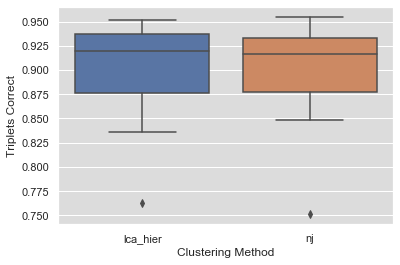

In [32]:
vals  = pd.melt(x)
sns.boxplot(x='variable', y='value', hue =init_cellsdata=vals)
plt.xlabel('Clustering Method')
plt.ylabel('Triplets Correct')
plt.show()

In [41]:
# x = pd.DataFrame(accs)
# x['init_cells'] = [simulation.init_cells for simulation in simulation_list]
pd.melt(x)

variable  value
0     lca_hier  0.876
1     lca_hier  0.836
2     lca_hier  0.928
3     lca_hier  0.940
4     lca_hier  0.902
5     lca_hier  0.763
6     lca_hier  0.920
7     lca_hier  0.937
8     lca_hier  0.952
9           nj  0.877
10          nj  0.848
11          nj  0.933
12          nj  0.944
13          nj  0.891
14          nj  0.751
15          nj  0.923
16          nj  0.917
17          nj  0.955
18  init_cells  1.000
19  init_cells  1.000
20  init_cells  1.000
21  init_cells  1.000
22  init_cells  1.000
23  init_cells  1.000
24  init_cells  1.000
25  init_cells  1.000
26  init_cells  1.000

In [ ]:
trees, acc = triplets_correct(simulation, inferred_trees={'nj':tree}, n_samples=1000)

In [ ]:
simulation.random_attr['nj_tree'].root().children 

TreeNode(name=)

In [ ]:
import modified_nj
importlib.reload(modified_nj)
import modified_nj

import time 
    
ourtimes = []
ouraccs = []

for simulation in simulation_list:
    fm = simulation.get_feature_matrix()

    dels_probs = simulation.get_edit_probs()
    # Try without weighted 
    dels_probs[dels_probs!=0] = np.exp(1)
    
    prob_features = dels_probs[fm.columns].values

    
    s = time.time()
    mod_tree, steps = modified_nj.mod_nj(simulation.feature_matrix.values, prob_features)
    ourtimes.append(time.time()-s)
    print('NJ Time:', time.time()-s)
    
#     print(mod_tree.ascii_art())
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':mod_tree}, n_samples=1000)
    ouraccs.append(acc['nj'])
    print('Triplets correct: ', acc)
    
    simulation.random_attr['unwt_tree'] = mod_tree
    
    simulation.random_attr['unwt_steps'] = steps
    try:
        why_are_trees_bad(simulation, mod_tree, steps)
    except Exception as e:
        print(e)

In [ ]:
for simulation in simulation_list:
    
    print('New Simulation: ')
    mod_tree = simulation.random_attr['tree']
    steps = simulation.random_attr['steps']
    left_tree = simulation.true_tree.root().children[0]
    right_tree = simulation.true_tree.root().children[1]

    left_tree = [x.name for x in left_tree.tips()]
    right_tree = [x.name for x in right_tree.tips()]

    side = {}

    bad_joins = []

    for i, join in enumerate(steps['joins']):

        # Determine which half of the tree the nodes lie in 
        for n1 in join:
            # See if n1 and n2 are both in the left 
            if str(n1) in left_tree:
                side[str(n1)] = 'L'
 
            elif str(n1) in right_tree:
                side[str(n1)] = 'R'
            else:
                # This is an internal node, look at its children
                child = mod_tree.find(str(n1)).children[0].name
                side[str(n1)] = side[child]

        n1, n2 = join

        if side[str(n1)] != side[str(n2)]:
            print('BAD JOIN: {0} AFTER {1}/{2} STEPS.'.format(join, i, len(steps['joins'])))
            bad_joins.append(join)

    def get_mut_prof(simulation, tree, node_name):
        if int(node_name) > 1000:
            c1, c2 = mod_tree.find(str(node_name)).children
            c1, c2 = c1.name, c2.name
            return get_mut_prof(simulation, tree, c1) * get_mut_prof(simulation, tree,c2)
        else:
            return simulation.feature_matrix.iloc[int(node_name)].values        

    for join in bad_joins:
        n1,n2 = join
        v1, v2 = int(n1), int(n2)

        print('Looking at: ', n1, n2)

        v1 = get_mut_prof(simulation, mod_tree, n1)
        v2 = get_mut_prof(simulation, mod_tree, n2)

        sns.heatmap([v1,v2], cmap='Paired')
        plt.show()
        plt.close()
        
        delprobs = simulation.get_edit_probs()[simulation.feature_matrix.columns].values.reshape(-1)
        
        plt.figure(figsize=(10,10))
        sns.heatmap([delprobs,v1,v2,delprobs], cmap='BuGn_r')
        plt.show()
        plt.close()
        
        # What are the probs of those edits?
        plt.show()

In [ ]:
for simulation in simulation_list:
    
    print('New Simulation: ')
    mod_tree = simulation.random_attr['tree']
    steps = simulation.random_attr['steps']
    left_tree = simulation.true_tree.root().children[0]
    right_tree = simulation.true_tree.root().children[1]

    left_tree = [x.name for x in left_tree.tips()]
    right_tree = [x.name for x in right_tree.tips()]

    side = {}

    bad_joins = []

    for i, join in enumerate(steps['joins']):

        # Determine which half of the tree the nodes lie in 
        for n1 in join:
            # See if n1 and n2 are both in the left 
            if str(n1) in left_tree:
                side[str(n1)] = 'L'

            elif str(n1) in right_tree:
                side[str(n1)] = 'R'
            else:
                # This is an internal node, look at its children
                child = mod_tree.find(str(n1)).children[0].name
                side[str(n1)] = side[child]

        n1, n2 = join

        if side[str(n1)] != side[str(n2)]:
            print('BAD JOIN: {0} AFTER {1}/{2} STEPS.'.format(join, i, len(steps['joins'])))
            bad_joins.append(join)

    def get_mut_prof(simulation, tree, node_name):
        if int(node_name) > 1000:
            c1, c2 = mod_tree.find(str(node_name)).children
            c1, c2 = c1.name, c2.name
            return get_mut_prof(simulation, tree, c1) * get_mut_prof(simulation, tree,c2)
        else:
            return simulation.feature_matrix.iloc[int(node_name)].values        

    for join in bad_joins:
        n1,n2 = join
        v1, v2 = int(n1), int(n2)

        print('Looking at: ', n1, n2)

        v1 = get_mut_prof(simulation, mod_tree, n1)
        v2 = get_mut_prof(simulation, mod_tree, n2)

        sns.heatmap([v1,v2], cmap='Paired')
        plt.show()
        plt.close()
        
        delprobs = simulation.get_edit_probs()[simulation.feature_matrix.columns].values.reshape(-1)
        
        plt.figure(figsize=(10,10))
        sns.heatmap([delprobs,v1,v2,delprobs], cmap='BuGn_r')
        plt.show()
        plt.close()
        
        # What are the probs of those edits?
        plt.show()

In [ ]:
theirtimes = []
theiraccs = []
for simulation in simulation_list:
    fm = simulation.get_feature_matrix()
    
    t = time.time()
    data = sklearn.metrics.pairwise_distances(fm.values, metric='hamming')
    dm = DistanceMatrix(data)

    norm_tree = nj(dm)
    
    theirtimes.append(time.time()-t)
    print('NJ Time:', time.time()-t)
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':norm_tree}, n_samples=1000)
    theiraccs.append(acc['nj'])
    
    simulation.random_attr['nj_tree'] = norm_tree
    
    print('Triplets correct: ', acc['nj'])
    
        
    

In [ ]:
norm_tree.root().children

In [ ]:
t1 = []
t1_labels = []

r1_kids, r2_kids = [None, None],  [None, None]
for i, child in enumerate(r1.children):
    leaves = [x.name for x in child.tips()] 
    t1 += leaves
    t1_labels += [i]*len(leaves)
    r1_kids[i] = child

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,15))
sns.boxplot(x='label', y='time (s)', hue='method', data=df, palette='Set1')

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,15))
sns.boxplot(x='label', y='acc', hue='method', data=df, palette='Set1')

In [ ]:
for g in range(1): #tree_depth):
    num_recurring = []

    for simulation in simulation_list:
        subsampled_edits = simulation.get_edit_record()
        subsampled_record = simulation.get_cell_record()


        # Investigating number of singletons, recurrent mutations and 'good' mutations 
        recurring_edits = {} # Mapping (site, deletion) to a list of generations where the mutation reoccured. 
        gen_occurred = {}
        for gen in range(simulation.tree_depth):
            rows, cols = np.where(subsampled_edits[gen]!=0)
            edits = subsampled_edits[gen][np.where(subsampled_edits[gen]!=0)]
            for col, edit in zip(cols, edits):
                # Track the generation that each mutation occurred
                gen_occurred[(col,edit)] = gen_occurred.get((col, edit), []) + [gen]
                # Track only recurrent mutations
                if ((subsampled_record[gen - 1 ][:, col] == edit).sum()) > 0:
                    # Add this (position, deletion) pair to the list of recurring muts
                    recurring_edits[(col, edit)] = recurring_edits.get((col, edit), []) + [gen]

        true = len(set(recurring_edits.keys()))

#         true = simulation.get_open_sites()[g]
#         num_recurring.append(true/simulation.feature_matrix.shape[1])
        num_recurring.append(np.mean(simulation.compute_unique_cells()[1:]))

    r, _ = pearsonr(num_recurring, ouraccs)
    plt.figure(figsize=(5,5))
    plt.ylabel('Accuracy')
    plt.scatter(num_recurring, ouraccs)
    plt.xlabel('Mean # Unique Cells \n r: {0:2f}'.format(r))
    plt.show()
    plt.close()

In [ ]:
len(list(mod_tree.children[0].tips()))

In [ ]:
len(list(mod_tree.children[1].tips()))

In [ ]:
from scipy.stats import pearsonr 

In [ ]:
sns.set_palette('Set1')

## After removing recurrent mutations

In [ ]:
ourtimes_no_recur = []
ouraccs_no_recur = []

for simulation in simulation_list:
    ignore = []
    for site, m in simulation.conflicting_muts:
        ignore.append(int(site*1000+m))
     
    fm = simulation.get_feature_matrix()
    print('Dropping {0} mutations from {1}.'.format(len(ignore), fm.shape[1]) )
    
    fm = fm.drop(ignore, axis=1)

    dels_probs = simulation.get_edit_probs()
    prob_features = dels_probs[fm.columns].values

    display(dels_probs[fm.columns])

    s = time.time()
    mod_tree, steps = modified_nj.mod_nj(fm.values, prob_features)
    ourtimes_no_recur.append(time.time()-s)
    print('NJ Time:', time.time()-s)
    
#     print(mod_tree.ascii_art())
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':mod_tree}, n_samples=1000)
    ouraccs_no_recur.append(acc['nj'])
    print('Triplets correct: ', acc)
    
    


In [ ]:
df = {'time (s)': ourtimes+ourtimes_no_recur, 'acc':ouraccs+ouraccs_no_recur, 'method':['with recur']*len(simulation_list)+['no_recur']*len(simulation_list), 
      'label':[simulation.label for simulation in simulation_list]+[simulation.label for simulation in simulation_list]}

df = pd.DataFrame(df)
df

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,15))
sns.boxplot(x='label', y='acc', hue='method', data=df, palette='Set1')

In [ ]:
len(simulation.truth_tape)

In [ ]:
len(simulation.conflicting_muts)

In [ ]:
ourtimes_no_recur_true = []
ouraccs_no_recur_true = []

for simulation in simulation_list:
    ignore = []
    true_recur = np.array(simulation.conflicting_muts)[np.array(simulation.truth_tape)==1]
    for site, m in true_recur:
        ignore.append(int(site*1000+m))
     
    fm = simulation.get_feature_matrix()
    print('Dropping {0} mutations from {1}.'.format(len(ignore), fm.shape[1]) )
    
    fm = fm.drop(ignore, axis=1)

    dels_probs = simulation.get_edit_probs()
    prob_features = dels_probs[fm.columns].values

    display(dels_probs[fm.columns])

    s = time.time()
    mod_tree, steps = modified_nj.mod_nj(fm.values, prob_features)
    ourtimes_no_recur_true.append(time.time()-s)
    print('NJ Time:', time.time()-s)
    
#     print(mod_tree.ascii_art())
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':mod_tree}, n_samples=1000)
    ouraccs_no_recur_true.append(acc['nj'])
    print('Triplets correct: ', acc)
    
    


In [ ]:
### Are the errors due to ambiguous scenarios? Where do we start going wrong 

In [ ]:
# Check the partitions at each level 

print("hi")

In [ ]:
why_are_trees_bad(simulation, mod_tree)

In [ ]:
simulation.cell_record[1]

In [ ]:
np.array(original)

In [ ]:
num_sites = simulation.cell_record[0].shape[1]
original = []
for site_num in range(num_sites):
    x = simulation.feature_matrix.columns[simulation.feature_matrix.columns<(site_num+1)*1000]
    x = x[x>site_num*1000]
    
    original.append((lcas[x]*(x-1000*site_num)).sum(1).values)
    
original = np.array(original).reshape(-1,num_sites)

In [ ]:
np.array(original).reshape(-1,)

In [ ]:
lcas